In [8]:
!echo $CONDA_DEFAULT_ENV

exp-tracking


In [9]:
!python -V

Python 3.9.12


In [10]:
import pandas as pd

In [11]:
import pickle

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
from sklearn.feature_extraction import DictVectorizer

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///../mlflow.db")
mlflow.set_experiment("nyc_taxi_exp")

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2022/05/30 01:39:34 INFO mlflow.tracking.fluent: Experiment with name 'nyc_taxi_exp' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc_taxi_exp', tags={}>

In [15]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'].copy())
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'].copy())
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str) 

In [16]:
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'].copy())
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'].copy())

In [17]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

In [18]:
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

In [19]:
#df = df[df['trip_type'] == 2]

In [20]:
df['duration'].describe(percentiles=[.95, .98, .99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [21]:
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

/home/sebastian/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

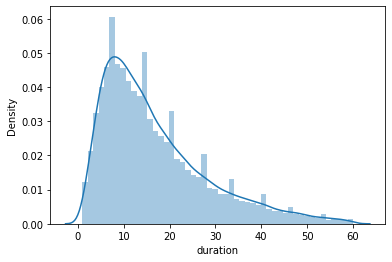

In [22]:
sns.distplot(df['duration'])

In [23]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [24]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [25]:
# One hot encoding
df[categorical] = df[categorical].astype(str) #Dictionary vectorizer takes as input non-integers

In [26]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [27]:
dv = DictVectorizer()

In [28]:
X_train = dv.fit_transform(train_dicts)

In [29]:
dv.feature_names_[:10]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11']

In [30]:
target = 'duration'
y_train = df[target].values

In [31]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [32]:
#Baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

/home/sebastian/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/sebastian/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


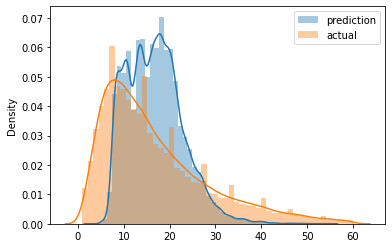

In [33]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()
plt.show()

In [34]:
mean_squared_error(y_train, y_pred, squared=False)

9.838799799886667

## Validation with February data

In [35]:
#Validate with February data
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'].copy())
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'].copy())
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str) 
    
    return df

In [36]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [37]:
len(df_train), len(df_val)

(73908, 61921)

In [38]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [39]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [41]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## Using MLflow to keep track of model iterations

In [44]:
with mlflow.start_run():
    mlflow.set_tag("Dev", "Sebastian")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    
    mlflow.log_param("alpha", alpha)
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

## Hyperparameter tuning using Xgboost

In [46]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [49]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [47]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[03:10:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.                                                         
[0]	validation-rmse:15.22993                                                                                                                                                   
[1]	validation-rmse:11.55314                                                                                                                                                   
[2]	validation-rmse:9.37262                                                                                                                                                    
[3]	validation-rmse:8.14095                                                                                                                                                    
[4]	validation-rmse:7.46556                                                                                             

[45]	validation-rmse:6.50349                                                                                                                                                   
[46]	validation-rmse:6.50335                                                                                                                                                   
[47]	validation-rmse:6.50050                                                                                                                                                   
[48]	validation-rmse:6.50072                                                                                                                                                   
[49]	validation-rmse:6.49999                                                                                                                                                   
[50]	validation-rmse:6.49899                                                                                            

[91]	validation-rmse:6.48906                                                                                                                                                   
[92]	validation-rmse:6.48812                                                                                                                                                   
[93]	validation-rmse:6.48779                                                                                                                                                   
[94]	validation-rmse:6.48730                                                                                                                                                   
[95]	validation-rmse:6.48705                                                                                                                                                   
[96]	validation-rmse:6.48667                                                                                            

[137]	validation-rmse:6.48349                                                                                                                                                  
[138]	validation-rmse:6.48345                                                                                                                                                  
[139]	validation-rmse:6.48294                                                                                                                                                  
[140]	validation-rmse:6.48284                                                                                                                                                  
[141]	validation-rmse:6.48324                                                                                                                                                  
[142]	validation-rmse:6.48422                                                                                           

[183]	validation-rmse:6.48522                                                                                                                                                  
[184]	validation-rmse:6.48533                                                                                                                                                  
[185]	validation-rmse:6.48566                                                                                                                                                  
[186]	validation-rmse:6.48608                                                                                                                                                  
[187]	validation-rmse:6.48614                                                                                                                                                  
[188]	validation-rmse:6.48641                                                                                           

[38]	validation-rmse:6.50633                                                                                                                                                   
[39]	validation-rmse:6.50406                                                                                                                                                   
[40]	validation-rmse:6.50422                                                                                                                                                   
[41]	validation-rmse:6.50326                                                                                                                                                   
[42]	validation-rmse:6.50173                                                                                                                                                   
[43]	validation-rmse:6.50031                                                                                            

[84]	validation-rmse:6.46711                                                                                                                                                   
[85]	validation-rmse:6.46504                                                                                                                                                   
[86]	validation-rmse:6.46460                                                                                                                                                   
[87]	validation-rmse:6.46395                                                                                                                                                   
[88]	validation-rmse:6.46313                                                                                                                                                   
[89]	validation-rmse:6.46251                                                                                            

[130]	validation-rmse:6.44632                                                                                                                                                  
[131]	validation-rmse:6.44611                                                                                                                                                  
[132]	validation-rmse:6.44622                                                                                                                                                  
[133]	validation-rmse:6.44628                                                                                                                                                  
[134]	validation-rmse:6.44357                                                                                                                                                  
[135]	validation-rmse:6.44295                                                                                           

[176]	validation-rmse:6.43980                                                                                                                                                  
[177]	validation-rmse:6.43957                                                                                                                                                  
[178]	validation-rmse:6.43899                                                                                                                                                  
[179]	validation-rmse:6.43867                                                                                                                                                  
[180]	validation-rmse:6.43855                                                                                                                                                  
[181]	validation-rmse:6.43841                                                                                           

[222]	validation-rmse:6.43713                                                                                                                                                  
[223]	validation-rmse:6.43703                                                                                                                                                  
[224]	validation-rmse:6.43717                                                                                                                                                  
[225]	validation-rmse:6.43706                                                                                                                                                  
[226]	validation-rmse:6.43720                                                                                                                                                  
[227]	validation-rmse:6.43713                                                                                           

[23]	validation-rmse:6.93273                                                                                                                                                   
[24]	validation-rmse:6.87696                                                                                                                                                   
[25]	validation-rmse:6.82888                                                                                                                                                   
[26]	validation-rmse:6.78575                                                                                                                                                   
[27]	validation-rmse:6.74820                                                                                                                                                   
[28]	validation-rmse:6.71653                                                                                            

[69]	validation-rmse:6.45836                                                                                                                                                   
[70]	validation-rmse:6.45766                                                                                                                                                   
[71]	validation-rmse:6.45681                                                                                                                                                   
[72]	validation-rmse:6.45624                                                                                                                                                   
[73]	validation-rmse:6.45514                                                                                                                                                   
[74]	validation-rmse:6.45457                                                                                            

[115]	validation-rmse:6.42803                                                                                                                                                  
[116]	validation-rmse:6.42750                                                                                                                                                  
[117]	validation-rmse:6.42692                                                                                                                                                  
[118]	validation-rmse:6.42655                                                                                                                                                  
[119]	validation-rmse:6.42611                                                                                                                                                  
[120]	validation-rmse:6.42581                                                                                           

[161]	validation-rmse:6.41088                                                                                                                                                  
[162]	validation-rmse:6.41080                                                                                                                                                  
[163]	validation-rmse:6.41041                                                                                                                                                  
[164]	validation-rmse:6.40998                                                                                                                                                  
[165]	validation-rmse:6.40977                                                                                                                                                  
[166]	validation-rmse:6.40945                                                                                           

[207]	validation-rmse:6.39966                                                                                                                                                  
[208]	validation-rmse:6.39945                                                                                                                                                  
[209]	validation-rmse:6.39923                                                                                                                                                  
[210]	validation-rmse:6.39906                                                                                                                                                  
[211]	validation-rmse:6.39862                                                                                                                                                  
[212]	validation-rmse:6.39830                                                                                           

[253]	validation-rmse:6.39084                                                                                                                                                  
[254]	validation-rmse:6.39057                                                                                                                                                  
[255]	validation-rmse:6.39052                                                                                                                                                  
[256]	validation-rmse:6.39042                                                                                                                                                  
[257]	validation-rmse:6.39019                                                                                                                                                  
[258]	validation-rmse:6.39008                                                                                           

[299]	validation-rmse:6.38341                                                                                                                                                  
[300]	validation-rmse:6.38307                                                                                                                                                  
[301]	validation-rmse:6.38311                                                                                                                                                  
[302]	validation-rmse:6.38326                                                                                                                                                  
[303]	validation-rmse:6.38322                                                                                                                                                  
[304]	validation-rmse:6.38227                                                                                           

[345]	validation-rmse:6.37807                                                                                                                                                  
[346]	validation-rmse:6.37816                                                                                                                                                  
[347]	validation-rmse:6.37794                                                                                                                                                  
[348]	validation-rmse:6.37785                                                                                                                                                  
[349]	validation-rmse:6.37794                                                                                                                                                  
[350]	validation-rmse:6.37789                                                                                           

[391]	validation-rmse:6.37626                                                                                                                                                  
[392]	validation-rmse:6.37626                                                                                                                                                  
[393]	validation-rmse:6.37602                                                                                                                                                  
[394]	validation-rmse:6.37602                                                                                                                                                  
[395]	validation-rmse:6.37599                                                                                                                                                  
[396]	validation-rmse:6.37599                                                                                           

[437]	validation-rmse:6.37420                                                                                                                                                  
[438]	validation-rmse:6.37400                                                                                                                                                  
[439]	validation-rmse:6.37400                                                                                                                                                  
[440]	validation-rmse:6.37377                                                                                                                                                  
[441]	validation-rmse:6.37378                                                                                                                                                  
[442]	validation-rmse:6.37382                                                                                           

[483]	validation-rmse:6.37391                                                                                                                                                  
[484]	validation-rmse:6.37377                                                                                                                                                  
[485]	validation-rmse:6.37373                                                                                                                                                  
[486]	validation-rmse:6.37372                                                                                                                                                  
[487]	validation-rmse:6.37373                                                                                                                                                  
[488]	validation-rmse:6.37365                                                                                           

[7]	validation-rmse:7.15476                                                                                                                                                    
[8]	validation-rmse:6.95609                                                                                                                                                    
[9]	validation-rmse:6.82323                                                                                                                                                    
[10]	validation-rmse:6.73081                                                                                                                                                   
[11]	validation-rmse:6.66756                                                                                                                                                   
[12]	validation-rmse:6.61943                                                                                            

[53]	validation-rmse:6.43587                                                                                                                                                   
[54]	validation-rmse:6.43533                                                                                                                                                   
[55]	validation-rmse:6.43469                                                                                                                                                   
[56]	validation-rmse:6.43329                                                                                                                                                   
[57]	validation-rmse:6.43215                                                                                                                                                   
[58]	validation-rmse:6.43225                                                                                            

[99]	validation-rmse:6.41547                                                                                                                                                   
[100]	validation-rmse:6.41548                                                                                                                                                  
[101]	validation-rmse:6.41537                                                                                                                                                  
[102]	validation-rmse:6.41586                                                                                                                                                  
[103]	validation-rmse:6.41606                                                                                                                                                  
[104]	validation-rmse:6.41580                                                                                           

[145]	validation-rmse:6.41160                                                                                                                                                  
[146]	validation-rmse:6.41146                                                                                                                                                  
[147]	validation-rmse:6.41117                                                                                                                                                  
[148]	validation-rmse:6.41108                                                                                                                                                  
[149]	validation-rmse:6.41081                                                                                                                                                  
[150]	validation-rmse:6.41060                                                                                           

[191]	validation-rmse:6.41328                                                                                                                                                  
[192]	validation-rmse:6.41342                                                                                                                                                  
[193]	validation-rmse:6.41316                                                                                                                                                  
[194]	validation-rmse:6.41283                                                                                                                                                  
[195]	validation-rmse:6.41282                                                                                                                                                  
[196]	validation-rmse:6.41387                                                                                           

[4]	validation-rmse:7.32408                                                                                                                                                    
[5]	validation-rmse:7.01564                                                                                                                                                    
[6]	validation-rmse:6.83615                                                                                                                                                    
[7]	validation-rmse:6.73657                                                                                                                                                    
[8]	validation-rmse:6.68052                                                                                                                                                    
[9]	validation-rmse:6.64667                                                                                             

[50]	validation-rmse:6.51221                                                                                                                                                   
[51]	validation-rmse:6.51145                                                                                                                                                   
[52]	validation-rmse:6.51082                                                                                                                                                   
[53]	validation-rmse:6.50981                                                                                                                                                   
[54]	validation-rmse:6.50949                                                                                                                                                   
[55]	validation-rmse:6.50894                                                                                            

[96]	validation-rmse:6.47439                                                                                                                                                   
[97]	validation-rmse:6.47352                                                                                                                                                   
[98]	validation-rmse:6.47186                                                                                                                                                   
[99]	validation-rmse:6.47049                                                                                                                                                   
[100]	validation-rmse:6.46970                                                                                                                                                  
[101]	validation-rmse:6.46905                                                                                           

[142]	validation-rmse:6.44237                                                                                                                                                  
[143]	validation-rmse:6.44229                                                                                                                                                  
[144]	validation-rmse:6.44160                                                                                                                                                  
[145]	validation-rmse:6.44126                                                                                                                                                  
[146]	validation-rmse:6.44105                                                                                                                                                  
[147]	validation-rmse:6.44192                                                                                           

[188]	validation-rmse:6.42851                                                                                                                                                  
[189]	validation-rmse:6.42793                                                                                                                                                  
[190]	validation-rmse:6.42780                                                                                                                                                  
[191]	validation-rmse:6.42703                                                                                                                                                  
[192]	validation-rmse:6.42718                                                                                                                                                  
[193]	validation-rmse:6.42723                                                                                           

[234]	validation-rmse:6.41758                                                                                                                                                  
[235]	validation-rmse:6.41688                                                                                                                                                  
[236]	validation-rmse:6.41686                                                                                                                                                  
[237]	validation-rmse:6.41636                                                                                                                                                  
[238]	validation-rmse:6.41712                                                                                                                                                  
[239]	validation-rmse:6.41653                                                                                           

[280]	validation-rmse:6.41068                                                                                                                                                  
[281]	validation-rmse:6.41088                                                                                                                                                  
[282]	validation-rmse:6.41084                                                                                                                                                  
[283]	validation-rmse:6.41067                                                                                                                                                  
[284]	validation-rmse:6.41059                                                                                                                                                  
[285]	validation-rmse:6.40994                                                                                           

[326]	validation-rmse:6.40401                                                                                                                                                  
[327]	validation-rmse:6.40403                                                                                                                                                  
[328]	validation-rmse:6.40349                                                                                                                                                  
[329]	validation-rmse:6.40354                                                                                                                                                  
[330]	validation-rmse:6.40432                                                                                                                                                  
[331]	validation-rmse:6.40417                                                                                           

[372]	validation-rmse:6.40682                                                                                                                                                  
[373]	validation-rmse:6.40726                                                                                                                                                  
[374]	validation-rmse:6.40731                                                                                                                                                  
[375]	validation-rmse:6.40698                                                                                                                                                  
[376]	validation-rmse:6.40705                                                                                                                                                  
[377]	validation-rmse:6.40729                                                                                           

[22]	validation-rmse:6.54313                                                                                                                                                   
[23]	validation-rmse:6.54018                                                                                                                                                   
[24]	validation-rmse:6.53663                                                                                                                                                   
[25]	validation-rmse:6.53378                                                                                                                                                   
[26]	validation-rmse:6.52865                                                                                                                                                   
[27]	validation-rmse:6.52576                                                                                            

[68]	validation-rmse:6.46590                                                                                                                                                   
[69]	validation-rmse:6.46492                                                                                                                                                   
[70]	validation-rmse:6.46265                                                                                                                                                   
[71]	validation-rmse:6.46142                                                                                                                                                   
[72]	validation-rmse:6.46015                                                                                                                                                   
[73]	validation-rmse:6.45828                                                                                            

[114]	validation-rmse:6.42701                                                                                                                                                  
[115]	validation-rmse:6.42569                                                                                                                                                  
[116]	validation-rmse:6.42542                                                                                                                                                  
[117]	validation-rmse:6.42514                                                                                                                                                  
[118]	validation-rmse:6.42450                                                                                                                                                  
[119]	validation-rmse:6.42465                                                                                           

[160]	validation-rmse:6.39772                                                                                                                                                  
[161]	validation-rmse:6.39678                                                                                                                                                  
[162]	validation-rmse:6.39604                                                                                                                                                  
[163]	validation-rmse:6.39544                                                                                                                                                  
[164]	validation-rmse:6.39453                                                                                                                                                  
[165]	validation-rmse:6.39434                                                                                           

[206]	validation-rmse:6.37746                                                                                                                                                  
[207]	validation-rmse:6.37696                                                                                                                                                  
[208]	validation-rmse:6.37617                                                                                                                                                  
[209]	validation-rmse:6.37561                                                                                                                                                  
[210]	validation-rmse:6.37534                                                                                                                                                  
[211]	validation-rmse:6.37507                                                                                           

[252]	validation-rmse:6.36001                                                                                                                                                  
[253]	validation-rmse:6.36017                                                                                                                                                  
[254]	validation-rmse:6.36019                                                                                                                                                  
[255]	validation-rmse:6.35961                                                                                                                                                  
[256]	validation-rmse:6.35887                                                                                                                                                  
[257]	validation-rmse:6.35820                                                                                           

[298]	validation-rmse:6.34380                                                                                                                                                  
[299]	validation-rmse:6.34342                                                                                                                                                  
[300]	validation-rmse:6.34331                                                                                                                                                  
[301]	validation-rmse:6.34314                                                                                                                                                  
[302]	validation-rmse:6.34323                                                                                                                                                  
[303]	validation-rmse:6.34337                                                                                           

[344]	validation-rmse:6.33153                                                                                                                                                  
[345]	validation-rmse:6.33130                                                                                                                                                  
[346]	validation-rmse:6.33117                                                                                                                                                  
[347]	validation-rmse:6.33083                                                                                                                                                  
[348]	validation-rmse:6.33068                                                                                                                                                  
[349]	validation-rmse:6.33060                                                                                           

[390]	validation-rmse:6.32255                                                                                                                                                  
[391]	validation-rmse:6.32287                                                                                                                                                  
[392]	validation-rmse:6.32260                                                                                                                                                  
[393]	validation-rmse:6.32263                                                                                                                                                  
[394]	validation-rmse:6.32247                                                                                                                                                  
[395]	validation-rmse:6.32224                                                                                           

[436]	validation-rmse:6.31645                                                                                                                                                  
[437]	validation-rmse:6.31640                                                                                                                                                  
[438]	validation-rmse:6.31631                                                                                                                                                  
[439]	validation-rmse:6.31620                                                                                                                                                  
[440]	validation-rmse:6.31555                                                                                                                                                  
[441]	validation-rmse:6.31515                                                                                           

[482]	validation-rmse:6.31032                                                                                                                                                  
[483]	validation-rmse:6.31019                                                                                                                                                  
[484]	validation-rmse:6.31023                                                                                                                                                  
[485]	validation-rmse:6.31011                                                                                                                                                  
[486]	validation-rmse:6.31014                                                                                                                                                  
[487]	validation-rmse:6.30988                                                                                           

[528]	validation-rmse:6.30454                                                                                                                                                  
[529]	validation-rmse:6.30458                                                                                                                                                  
[530]	validation-rmse:6.30452                                                                                                                                                  
[531]	validation-rmse:6.30434                                                                                                                                                  
[532]	validation-rmse:6.30433                                                                                                                                                  
[533]	validation-rmse:6.30413                                                                                           

[574]	validation-rmse:6.30067                                                                                                                                                  
[575]	validation-rmse:6.30069                                                                                                                                                  
[576]	validation-rmse:6.30073                                                                                                                                                  
[577]	validation-rmse:6.30064                                                                                                                                                  
[578]	validation-rmse:6.30064                                                                                                                                                  
[579]	validation-rmse:6.30024                                                                                           

[620]	validation-rmse:6.29812                                                                                                                                                  
[621]	validation-rmse:6.29810                                                                                                                                                  
[622]	validation-rmse:6.29819                                                                                                                                                  
[623]	validation-rmse:6.29810                                                                                                                                                  
[624]	validation-rmse:6.29800                                                                                                                                                  
[625]	validation-rmse:6.29778                                                                                           

[666]	validation-rmse:6.29589                                                                                                                                                  
[667]	validation-rmse:6.29578                                                                                                                                                  
[668]	validation-rmse:6.29555                                                                                                                                                  
[669]	validation-rmse:6.29561                                                                                                                                                  
[670]	validation-rmse:6.29575                                                                                                                                                  
[671]	validation-rmse:6.29580                                                                                           

[712]	validation-rmse:6.29280                                                                                                                                                  
[713]	validation-rmse:6.29282                                                                                                                                                  
[714]	validation-rmse:6.29269                                                                                                                                                  
[715]	validation-rmse:6.29276                                                                                                                                                  
[716]	validation-rmse:6.29296                                                                                                                                                  
[717]	validation-rmse:6.29278                                                                                           

[758]	validation-rmse:6.29152                                                                                                                                                  
[759]	validation-rmse:6.29139                                                                                                                                                  
[760]	validation-rmse:6.29145                                                                                                                                                  
[761]	validation-rmse:6.29128                                                                                                                                                  
[762]	validation-rmse:6.29141                                                                                                                                                  
[763]	validation-rmse:6.29126                                                                                           

[7]	validation-rmse:7.35784                                                                                                                                                    
[8]	validation-rmse:7.12133                                                                                                                                                    
[9]	validation-rmse:6.96173                                                                                                                                                    
[10]	validation-rmse:6.85007                                                                                                                                                   
[11]	validation-rmse:6.77250                                                                                                                                                   
[12]	validation-rmse:6.71406                                                                                            

[53]	validation-rmse:6.51674                                                                                                                                                   
[54]	validation-rmse:6.51480                                                                                                                                                   
[55]	validation-rmse:6.51448                                                                                                                                                   
[56]	validation-rmse:6.51348                                                                                                                                                   
[57]	validation-rmse:6.51311                                                                                                                                                   
[58]	validation-rmse:6.51249                                                                                            

[99]	validation-rmse:6.50048                                                                                                                                                   
[100]	validation-rmse:6.50018                                                                                                                                                  
[101]	validation-rmse:6.50025                                                                                                                                                  
[102]	validation-rmse:6.49993                                                                                                                                                  
[103]	validation-rmse:6.49986                                                                                                                                                  
[104]	validation-rmse:6.49966                                                                                           

[145]	validation-rmse:6.49649                                                                                                                                                  
[146]	validation-rmse:6.49585                                                                                                                                                  
[147]	validation-rmse:6.49582                                                                                                                                                  
[148]	validation-rmse:6.49572                                                                                                                                                  
[149]	validation-rmse:6.49567                                                                                                                                                  
[150]	validation-rmse:6.49569                                                                                           

[191]	validation-rmse:6.49571                                                                                                                                                  
[192]	validation-rmse:6.49583                                                                                                                                                  
[193]	validation-rmse:6.49582                                                                                                                                                  
[194]	validation-rmse:6.49582                                                                                                                                                  
[195]	validation-rmse:6.49583                                                                                                                                                  
[196]	validation-rmse:6.49559                                                                                           

[18]	validation-rmse:6.93019                                                                                                                                                   
[19]	validation-rmse:6.89156                                                                                                                                                   
[20]	validation-rmse:6.86090                                                                                                                                                   
[21]	validation-rmse:6.83204                                                                                                                                                   
[22]	validation-rmse:6.81013                                                                                                                                                   
[23]	validation-rmse:6.78970                                                                                            

[64]	validation-rmse:6.68560                                                                                                                                                   
[65]	validation-rmse:6.68492                                                                                                                                                   
[66]	validation-rmse:6.68481                                                                                                                                                   
[67]	validation-rmse:6.68489                                                                                                                                                   
[68]	validation-rmse:6.68443                                                                                                                                                   
[69]	validation-rmse:6.68416                                                                                            

[110]	validation-rmse:6.68080                                                                                                                                                  
[111]	validation-rmse:6.68101                                                                                                                                                  
[112]	validation-rmse:6.68105                                                                                                                                                  
[113]	validation-rmse:6.68089                                                                                                                                                  
[114]	validation-rmse:6.68077                                                                                                                                                  
[115]	validation-rmse:6.68094                                                                                           

[156]	validation-rmse:6.68375                                                                                                                                                  
[157]	validation-rmse:6.68321                                                                                                                                                  
[158]	validation-rmse:6.68320                                                                                                                                                  
[159]	validation-rmse:6.68342                                                                                                                                                  
[160]	validation-rmse:6.68335                                                                                                                                                  
[161]	validation-rmse:6.68347                                                                                           

[37]	validation-rmse:6.46811                                                                                                                                                   
[38]	validation-rmse:6.46956                                                                                                                                                   
[39]	validation-rmse:6.46601                                                                                                                                                   
[40]	validation-rmse:6.46629                                                                                                                                                   
[41]	validation-rmse:6.46684                                                                                                                                                   
[42]	validation-rmse:6.46653                                                                                            

[83]	validation-rmse:6.47010                                                                                                                                                   
[84]	validation-rmse:6.47047                                                                                                                                                   
[85]	validation-rmse:6.47047                                                                                                                                                   
[86]	validation-rmse:6.47052                                                                                                                                                   
[87]	validation-rmse:6.47104                                                                                                                                                   
[88]	validation-rmse:6.47067                                                                                            

[9]	validation-rmse:8.24102                                                                                                                                                    
[10]	validation-rmse:7.89867                                                                                                                                                   
[11]	validation-rmse:7.62529                                                                                                                                                   
[12]	validation-rmse:7.40698                                                                                                                                                   
[13]	validation-rmse:7.23396                                                                                                                                                   
[14]	validation-rmse:7.09494                                                                                            

[55]	validation-rmse:6.45269                                                                                                                                                   
[56]	validation-rmse:6.45152                                                                                                                                                   
[57]	validation-rmse:6.45014                                                                                                                                                   
[58]	validation-rmse:6.44935                                                                                                                                                   
[59]	validation-rmse:6.44813                                                                                                                                                   
[60]	validation-rmse:6.44717                                                                                            

[101]	validation-rmse:6.42172                                                                                                                                                  
[102]	validation-rmse:6.42134                                                                                                                                                  
[103]	validation-rmse:6.42082                                                                                                                                                  
[104]	validation-rmse:6.42029                                                                                                                                                  
[105]	validation-rmse:6.41991                                                                                                                                                  
[106]	validation-rmse:6.41966                                                                                           

[147]	validation-rmse:6.40448                                                                                                                                                  
[148]	validation-rmse:6.40428                                                                                                                                                  
[149]	validation-rmse:6.40381                                                                                                                                                  
[150]	validation-rmse:6.40359                                                                                                                                                  
[151]	validation-rmse:6.40320                                                                                                                                                  
[152]	validation-rmse:6.40303                                                                                           

[193]	validation-rmse:6.39410                                                                                                                                                  
[194]	validation-rmse:6.39389                                                                                                                                                  
[195]	validation-rmse:6.39393                                                                                                                                                  
[196]	validation-rmse:6.39363                                                                                                                                                  
[197]	validation-rmse:6.39355                                                                                                                                                  
[198]	validation-rmse:6.39325                                                                                           

[239]	validation-rmse:6.38929                                                                                                                                                  
[240]	validation-rmse:6.38936                                                                                                                                                  
[241]	validation-rmse:6.38930                                                                                                                                                  
[242]	validation-rmse:6.38947                                                                                                                                                  
[243]	validation-rmse:6.38924                                                                                                                                                  
[244]	validation-rmse:6.38882                                                                                           

[285]	validation-rmse:6.38760                                                                                                                                                  
[286]	validation-rmse:6.38731                                                                                                                                                  
[287]	validation-rmse:6.38729                                                                                                                                                  
[288]	validation-rmse:6.38726                                                                                                                                                  
[289]	validation-rmse:6.38705                                                                                                                                                  
[290]	validation-rmse:6.38701                                                                                           

[331]	validation-rmse:6.38927                                                                                                                                                  
[332]	validation-rmse:6.39009                                                                                                                                                  
[333]	validation-rmse:6.39014                                                                                                                                                  
[334]	validation-rmse:6.39024                                                                                                                                                  
[335]	validation-rmse:6.39053                                                                                                                                                  
[336]	validation-rmse:6.38987                                                                                           

[33]	validation-rmse:6.88155                                                                                                                                                   
[34]	validation-rmse:6.85905                                                                                                                                                   
[35]	validation-rmse:6.83932                                                                                                                                                   
[36]	validation-rmse:6.82196                                                                                                                                                   
[37]	validation-rmse:6.80589                                                                                                                                                   
[38]	validation-rmse:6.79270                                                                                            

[79]	validation-rmse:6.65708                                                                                                                                                   
[80]	validation-rmse:6.65677                                                                                                                                                   
[81]	validation-rmse:6.65641                                                                                                                                                   
[82]	validation-rmse:6.65592                                                                                                                                                   
[83]	validation-rmse:6.65544                                                                                                                                                   
[84]	validation-rmse:6.65517                                                                                            

[125]	validation-rmse:6.64808                                                                                                                                                  
[126]	validation-rmse:6.64786                                                                                                                                                  
[127]	validation-rmse:6.64790                                                                                                                                                  
[128]	validation-rmse:6.64791                                                                                                                                                  
[129]	validation-rmse:6.64772                                                                                                                                                  
[130]	validation-rmse:6.64761                                                                                           

[171]	validation-rmse:6.64619                                                                                                                                                  
[172]	validation-rmse:6.64631                                                                                                                                                  
[173]	validation-rmse:6.64627                                                                                                                                                  
[174]	validation-rmse:6.64620                                                                                                                                                  
[175]	validation-rmse:6.64618                                                                                                                                                  
[176]	validation-rmse:6.64623                                                                                           

[217]	validation-rmse:6.64566                                                                                                                                                  
[218]	validation-rmse:6.64554                                                                                                                                                  
[219]	validation-rmse:6.64550                                                                                                                                                  
[220]	validation-rmse:6.64555                                                                                                                                                  
[221]	validation-rmse:6.64551                                                                                                                                                  
[222]	validation-rmse:6.64537                                                                                           

[263]	validation-rmse:6.64454                                                                                                                                                  
[264]	validation-rmse:6.64426                                                                                                                                                  
[265]	validation-rmse:6.64411                                                                                                                                                  
[266]	validation-rmse:6.64424                                                                                                                                                  
[267]	validation-rmse:6.64419                                                                                                                                                  
[268]	validation-rmse:6.64385                                                                                           

[309]	validation-rmse:6.64392                                                                                                                                                  
[310]	validation-rmse:6.64404                                                                                                                                                  
[311]	validation-rmse:6.64392                                                                                                                                                  
[312]	validation-rmse:6.64388                                                                                                                                                  
[313]	validation-rmse:6.64380                                                                                                                                                  
[314]	validation-rmse:6.64379                                                                                           

[22]	validation-rmse:6.67415                                                                                                                                                   
[23]	validation-rmse:6.64407                                                                                                                                                   
[24]	validation-rmse:6.61878                                                                                                                                                   
[25]	validation-rmse:6.59747                                                                                                                                                   
[26]	validation-rmse:6.57993                                                                                                                                                   
[27]	validation-rmse:6.56399                                                                                            

[68]	validation-rmse:6.44950                                                                                                                                                   
[69]	validation-rmse:6.44863                                                                                                                                                   
[70]	validation-rmse:6.44780                                                                                                                                                   
[71]	validation-rmse:6.44701                                                                                                                                                   
[72]	validation-rmse:6.44630                                                                                                                                                   
[73]	validation-rmse:6.44562                                                                                            

[114]	validation-rmse:6.42628                                                                                                                                                  
[115]	validation-rmse:6.42562                                                                                                                                                  
[116]	validation-rmse:6.42548                                                                                                                                                  
[117]	validation-rmse:6.42493                                                                                                                                                  
[118]	validation-rmse:6.42475                                                                                                                                                  
[119]	validation-rmse:6.42454                                                                                           

[160]	validation-rmse:6.41429                                                                                                                                                  
[161]	validation-rmse:6.41404                                                                                                                                                  
[162]	validation-rmse:6.41409                                                                                                                                                  
[163]	validation-rmse:6.41420                                                                                                                                                  
[164]	validation-rmse:6.41414                                                                                                                                                  
[165]	validation-rmse:6.41360                                                                                           

[206]	validation-rmse:6.40905                                                                                                                                                  
[207]	validation-rmse:6.40892                                                                                                                                                  
[208]	validation-rmse:6.40910                                                                                                                                                  
[209]	validation-rmse:6.40876                                                                                                                                                  
[210]	validation-rmse:6.40868                                                                                                                                                  
[211]	validation-rmse:6.40883                                                                                           

[252]	validation-rmse:6.40847                                                                                                                                                  
[253]	validation-rmse:6.40843                                                                                                                                                  
[254]	validation-rmse:6.40902                                                                                                                                                  
[255]	validation-rmse:6.40901                                                                                                                                                  
[256]	validation-rmse:6.40902                                                                                                                                                  
[257]	validation-rmse:6.40875                                                                                           

[298]	validation-rmse:6.40991                                                                                                                                                  
[03:22:55] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.                                                         
[0]	validation-rmse:20.29981                                                                                                                                                   
[1]	validation-rmse:19.45707                                                                                                                                                   
[2]	validation-rmse:18.65844                                                                                                                                                   
[3]	validation-rmse:17.90717                                                                                            

[44]	validation-rmse:7.20900                                                                                                                                                   
[45]	validation-rmse:7.16439                                                                                                                                                   
[46]	validation-rmse:7.12404                                                                                                                                                   
[47]	validation-rmse:7.08765                                                                                                                                                   
[48]	validation-rmse:7.05260                                                                                                                                                   
[49]	validation-rmse:7.01896                                                                                            

[90]	validation-rmse:6.56512                                                                                                                                                   
[91]	validation-rmse:6.56220                                                                                                                                                   
[92]	validation-rmse:6.55979                                                                                                                                                   
[93]	validation-rmse:6.55728                                                                                                                                                   
[94]	validation-rmse:6.55477                                                                                                                                                   
[95]	validation-rmse:6.55258                                                                                            

[136]	validation-rmse:6.50722                                                                                                                                                  
[137]	validation-rmse:6.50685                                                                                                                                                  
[138]	validation-rmse:6.50609                                                                                                                                                  
[139]	validation-rmse:6.50549                                                                                                                                                  
[140]	validation-rmse:6.50497                                                                                                                                                  
[141]	validation-rmse:6.50447                                                                                           

[182]	validation-rmse:6.48913                                                                                                                                                  
[183]	validation-rmse:6.48889                                                                                                                                                  
[184]	validation-rmse:6.48856                                                                                                                                                  
[185]	validation-rmse:6.48819                                                                                                                                                  
[186]	validation-rmse:6.48790                                                                                                                                                  
[187]	validation-rmse:6.48744                                                                                           

[228]	validation-rmse:6.47734                                                                                                                                                  
[229]	validation-rmse:6.47715                                                                                                                                                  
[230]	validation-rmse:6.47709                                                                                                                                                  
[231]	validation-rmse:6.47683                                                                                                                                                  
[232]	validation-rmse:6.47658                                                                                                                                                  
[233]	validation-rmse:6.47640                                                                                           

[274]	validation-rmse:6.46832                                                                                                                                                  
[275]	validation-rmse:6.46807                                                                                                                                                  
[276]	validation-rmse:6.46787                                                                                                                                                  
[277]	validation-rmse:6.46779                                                                                                                                                  
[278]	validation-rmse:6.46768                                                                                                                                                  
[279]	validation-rmse:6.46742                                                                                           

[320]	validation-rmse:6.46015                                                                                                                                                  
[321]	validation-rmse:6.45997                                                                                                                                                  
[322]	validation-rmse:6.45993                                                                                                                                                  
[323]	validation-rmse:6.45977                                                                                                                                                  
[324]	validation-rmse:6.45964                                                                                                                                                  
[325]	validation-rmse:6.45941                                                                                           

[366]	validation-rmse:6.45410                                                                                                                                                  
[367]	validation-rmse:6.45396                                                                                                                                                  
[368]	validation-rmse:6.45383                                                                                                                                                  
[369]	validation-rmse:6.45380                                                                                                                                                  
[370]	validation-rmse:6.45375                                                                                                                                                  
[371]	validation-rmse:6.45376                                                                                           

[412]	validation-rmse:6.44842                                                                                                                                                  
[413]	validation-rmse:6.44837                                                                                                                                                  
[414]	validation-rmse:6.44836                                                                                                                                                  
[415]	validation-rmse:6.44823                                                                                                                                                  
[416]	validation-rmse:6.44811                                                                                                                                                  
[417]	validation-rmse:6.44796                                                                                           

[458]	validation-rmse:6.44270                                                                                                                                                  
[459]	validation-rmse:6.44267                                                                                                                                                  
[460]	validation-rmse:6.44266                                                                                                                                                  
[461]	validation-rmse:6.44261                                                                                                                                                  
[462]	validation-rmse:6.44245                                                                                                                                                  
[463]	validation-rmse:6.44243                                                                                           

[504]	validation-rmse:6.43847                                                                                                                                                  
[505]	validation-rmse:6.43842                                                                                                                                                  
[506]	validation-rmse:6.43833                                                                                                                                                  
[507]	validation-rmse:6.43825                                                                                                                                                  
[508]	validation-rmse:6.43818                                                                                                                                                  
[509]	validation-rmse:6.43814                                                                                           

[550]	validation-rmse:6.43490                                                                                                                                                  
[551]	validation-rmse:6.43477                                                                                                                                                  
[552]	validation-rmse:6.43469                                                                                                                                                  
[553]	validation-rmse:6.43455                                                                                                                                                  
[554]	validation-rmse:6.43438                                                                                                                                                  
[555]	validation-rmse:6.43421                                                                                           

[596]	validation-rmse:6.43179                                                                                                                                                  
[597]	validation-rmse:6.43171                                                                                                                                                  
[598]	validation-rmse:6.43166                                                                                                                                                  
[599]	validation-rmse:6.43168                                                                                                                                                  
[600]	validation-rmse:6.43167                                                                                                                                                  
[601]	validation-rmse:6.43155                                                                                           

[642]	validation-rmse:6.42863                                                                                                                                                  
[643]	validation-rmse:6.42862                                                                                                                                                  
[644]	validation-rmse:6.42863                                                                                                                                                  
[645]	validation-rmse:6.42864                                                                                                                                                  
[646]	validation-rmse:6.42874                                                                                                                                                  
[647]	validation-rmse:6.42862                                                                                           

[688]	validation-rmse:6.42618                                                                                                                                                  
[689]	validation-rmse:6.42609                                                                                                                                                  
[690]	validation-rmse:6.42612                                                                                                                                                  
[691]	validation-rmse:6.42605                                                                                                                                                  
[692]	validation-rmse:6.42599                                                                                                                                                  
[693]	validation-rmse:6.42594                                                                                           

[734]	validation-rmse:6.42384                                                                                                                                                  
[735]	validation-rmse:6.42374                                                                                                                                                  
[736]	validation-rmse:6.42367                                                                                                                                                  
[737]	validation-rmse:6.42357                                                                                                                                                  
[738]	validation-rmse:6.42350                                                                                                                                                  
[739]	validation-rmse:6.42344                                                                                           

[780]	validation-rmse:6.42184                                                                                                                                                  
[781]	validation-rmse:6.42176                                                                                                                                                  
[782]	validation-rmse:6.42176                                                                                                                                                  
[783]	validation-rmse:6.42171                                                                                                                                                  
[784]	validation-rmse:6.42168                                                                                                                                                  
[785]	validation-rmse:6.42165                                                                                           

[826]	validation-rmse:6.41981                                                                                                                                                  
[827]	validation-rmse:6.41975                                                                                                                                                  
[828]	validation-rmse:6.41982                                                                                                                                                  
[829]	validation-rmse:6.41989                                                                                                                                                  
[830]	validation-rmse:6.41982                                                                                                                                                  
[831]	validation-rmse:6.41979                                                                                           

[872]	validation-rmse:6.41837                                                                                                                                                  
[873]	validation-rmse:6.41832                                                                                                                                                  
[874]	validation-rmse:6.41820                                                                                                                                                  
[875]	validation-rmse:6.41809                                                                                                                                                  
[876]	validation-rmse:6.41809                                                                                                                                                  
[877]	validation-rmse:6.41801                                                                                           

[918]	validation-rmse:6.41671                                                                                                                                                  
[919]	validation-rmse:6.41665                                                                                                                                                  
[920]	validation-rmse:6.41665                                                                                                                                                  
[921]	validation-rmse:6.41667                                                                                                                                                  
[922]	validation-rmse:6.41659                                                                                                                                                  
[923]	validation-rmse:6.41668                                                                                           

[964]	validation-rmse:6.41529                                                                                                                                                  
[965]	validation-rmse:6.41526                                                                                                                                                  
[966]	validation-rmse:6.41515                                                                                                                                                  
[967]	validation-rmse:6.41505                                                                                                                                                  
[968]	validation-rmse:6.41499                                                                                                                                                  
[969]	validation-rmse:6.41493                                                                                           

[9]	validation-rmse:6.67093                                                                                                                                                    
[10]	validation-rmse:6.66759                                                                                                                                                   
[11]	validation-rmse:6.66129                                                                                                                                                   
[12]	validation-rmse:6.66048                                                                                                                                                   
[13]	validation-rmse:6.65717                                                                                                                                                   
[14]	validation-rmse:6.65400                                                                                            

[55]	validation-rmse:6.57596                                                                                                                                                   
[56]	validation-rmse:6.57529                                                                                                                                                   
[57]	validation-rmse:6.57199                                                                                                                                                   
[58]	validation-rmse:6.56969                                                                                                                                                   
[59]	validation-rmse:6.56770                                                                                                                                                   
[60]	validation-rmse:6.56749                                                                                            

[101]	validation-rmse:6.52284                                                                                                                                                  
[102]	validation-rmse:6.52341                                                                                                                                                  
[103]	validation-rmse:6.52261                                                                                                                                                  
[104]	validation-rmse:6.52131                                                                                                                                                  
[105]	validation-rmse:6.51992                                                                                                                                                  
[106]	validation-rmse:6.51936                                                                                           

[147]	validation-rmse:6.49479                                                                                                                                                  
[148]	validation-rmse:6.49357                                                                                                                                                  
[149]	validation-rmse:6.49808                                                                                                                                                  
[150]	validation-rmse:6.49798                                                                                                                                                  
[151]	validation-rmse:6.49738                                                                                                                                                  
[152]	validation-rmse:6.49759                                                                                           

[193]	validation-rmse:6.47331                                                                                                                                                  
[194]	validation-rmse:6.47264                                                                                                                                                  
[195]	validation-rmse:6.47226                                                                                                                                                  
[196]	validation-rmse:6.47092                                                                                                                                                  
[197]	validation-rmse:6.47049                                                                                                                                                  
[198]	validation-rmse:6.47024                                                                                           

[239]	validation-rmse:6.45656                                                                                                                                                  
[240]	validation-rmse:6.45557                                                                                                                                                  
[241]	validation-rmse:6.45486                                                                                                                                                  
[242]	validation-rmse:6.45421                                                                                                                                                  
[243]	validation-rmse:6.45413                                                                                                                                                  
[244]	validation-rmse:6.45444                                                                                           

[285]	validation-rmse:6.44322                                                                                                                                                  
[286]	validation-rmse:6.44273                                                                                                                                                  
[287]	validation-rmse:6.44215                                                                                                                                                  
[288]	validation-rmse:6.44193                                                                                                                                                  
[289]	validation-rmse:6.44200                                                                                                                                                  
[290]	validation-rmse:6.44159                                                                                           

[331]	validation-rmse:6.43203                                                                                                                                                  
[332]	validation-rmse:6.43206                                                                                                                                                  
[333]	validation-rmse:6.43217                                                                                                                                                  
[334]	validation-rmse:6.43252                                                                                                                                                  
[335]	validation-rmse:6.43290                                                                                                                                                  
[336]	validation-rmse:6.43278                                                                                           

[377]	validation-rmse:6.41751                                                                                                                                                  
[378]	validation-rmse:6.41709                                                                                                                                                  
[379]	validation-rmse:6.41754                                                                                                                                                  
[380]	validation-rmse:6.41731                                                                                                                                                  
[381]	validation-rmse:6.41683                                                                                                                                                  
[382]	validation-rmse:6.41698                                                                                           

[423]	validation-rmse:6.40828                                                                                                                                                  
[424]	validation-rmse:6.40823                                                                                                                                                  
[425]	validation-rmse:6.40783                                                                                                                                                  
[426]	validation-rmse:6.40751                                                                                                                                                  
[427]	validation-rmse:6.40689                                                                                                                                                  
[428]	validation-rmse:6.40985                                                                                           

[469]	validation-rmse:6.40641                                                                                                                                                  
[470]	validation-rmse:6.40626                                                                                                                                                  
[471]	validation-rmse:6.40582                                                                                                                                                  
[472]	validation-rmse:6.40608                                                                                                                                                  
[473]	validation-rmse:6.40608                                                                                                                                                  
[474]	validation-rmse:6.40585                                                                                           

[515]	validation-rmse:6.39969                                                                                                                                                  
[516]	validation-rmse:6.39953                                                                                                                                                  
[517]	validation-rmse:6.39919                                                                                                                                                  
[518]	validation-rmse:6.39923                                                                                                                                                  
[519]	validation-rmse:6.39907                                                                                                                                                  
[520]	validation-rmse:6.39879                                                                                           

[561]	validation-rmse:6.39646                                                                                                                                                  
[562]	validation-rmse:6.39660                                                                                                                                                  
[563]	validation-rmse:6.39609                                                                                                                                                  
[564]	validation-rmse:6.39577                                                                                                                                                  
[565]	validation-rmse:6.39558                                                                                                                                                  
[566]	validation-rmse:6.39507                                                                                           

[607]	validation-rmse:6.39432                                                                                                                                                  
[608]	validation-rmse:6.39473                                                                                                                                                  
[609]	validation-rmse:6.39441                                                                                                                                                  
[610]	validation-rmse:6.39434                                                                                                                                                  
[611]	validation-rmse:6.39407                                                                                                                                                  
[612]	validation-rmse:6.39380                                                                                           

[653]	validation-rmse:6.39180                                                                                                                                                  
[654]	validation-rmse:6.39198                                                                                                                                                  
[655]	validation-rmse:6.39176                                                                                                                                                  
[656]	validation-rmse:6.39168                                                                                                                                                  
[657]	validation-rmse:6.39157                                                                                                                                                  
[658]	validation-rmse:6.39162                                                                                           

[699]	validation-rmse:6.38854                                                                                                                                                  
[700]	validation-rmse:6.38877                                                                                                                                                  
[701]	validation-rmse:6.38875                                                                                                                                                  
[702]	validation-rmse:6.38860                                                                                                                                                  
[703]	validation-rmse:6.38859                                                                                                                                                  
[704]	validation-rmse:6.38845                                                                                           

[745]	validation-rmse:6.38653                                                                                                                                                  
[746]	validation-rmse:6.38661                                                                                                                                                  
[747]	validation-rmse:6.38629                                                                                                                                                  
[748]	validation-rmse:6.38588                                                                                                                                                  
[749]	validation-rmse:6.38566                                                                                                                                                  
[750]	validation-rmse:6.38554                                                                                           

[791]	validation-rmse:6.38744                                                                                                                                                  
[792]	validation-rmse:6.38696                                                                                                                                                  
[793]	validation-rmse:6.38657                                                                                                                                                  
[794]	validation-rmse:6.38717                                                                                                                                                  
[795]	validation-rmse:6.38738                                                                                                                                                  
[796]	validation-rmse:6.38729                                                                                           

[10]	validation-rmse:6.49912                                                                                                                                                   
[11]	validation-rmse:6.48272                                                                                                                                                   
[12]	validation-rmse:6.47077                                                                                                                                                   
[13]	validation-rmse:6.46189                                                                                                                                                   
[14]	validation-rmse:6.45495                                                                                                                                                   
[15]	validation-rmse:6.44931                                                                                            

[56]	validation-rmse:6.36519                                                                                                                                                   
[57]	validation-rmse:6.36383                                                                                                                                                   
[58]	validation-rmse:6.36358                                                                                                                                                   
[59]	validation-rmse:6.36210                                                                                                                                                   
[60]	validation-rmse:6.36039                                                                                                                                                   
[61]	validation-rmse:6.35976                                                                                            

[102]	validation-rmse:6.33417                                                                                                                                                  
[103]	validation-rmse:6.33406                                                                                                                                                  
[104]	validation-rmse:6.33367                                                                                                                                                  
[105]	validation-rmse:6.33308                                                                                                                                                  
[106]	validation-rmse:6.33240                                                                                                                                                  
[107]	validation-rmse:6.33148                                                                                           

[148]	validation-rmse:6.32195                                                                                                                                                  
[149]	validation-rmse:6.32130                                                                                                                                                  
[150]	validation-rmse:6.32124                                                                                                                                                  
[151]	validation-rmse:6.32092                                                                                                                                                  
[152]	validation-rmse:6.32108                                                                                                                                                  
[153]	validation-rmse:6.32100                                                                                           

[194]	validation-rmse:6.31583                                                                                                                                                  
[195]	validation-rmse:6.31535                                                                                                                                                  
[196]	validation-rmse:6.31506                                                                                                                                                  
[197]	validation-rmse:6.31491                                                                                                                                                  
[198]	validation-rmse:6.31469                                                                                                                                                  
[199]	validation-rmse:6.31451                                                                                           

[240]	validation-rmse:6.31969                                                                                                                                                  
[241]	validation-rmse:6.31999                                                                                                                                                  
[242]	validation-rmse:6.32037                                                                                                                                                  
[243]	validation-rmse:6.32076                                                                                                                                                  
[244]	validation-rmse:6.32041                                                                                                                                                  
[245]	validation-rmse:6.32038                                                                                           

[22]	validation-rmse:9.40085                                                                                                                                                   
[23]	validation-rmse:9.19605                                                                                                                                                   
[24]	validation-rmse:9.00727                                                                                                                                                   
[25]	validation-rmse:8.83101                                                                                                                                                   
[26]	validation-rmse:8.67011                                                                                                                                                   
[27]	validation-rmse:8.52033                                                                                            

[68]	validation-rmse:6.69547                                                                                                                                                   
[69]	validation-rmse:6.68798                                                                                                                                                   
[70]	validation-rmse:6.68166                                                                                                                                                   
[71]	validation-rmse:6.67494                                                                                                                                                   
[72]	validation-rmse:6.66824                                                                                                                                                   
[73]	validation-rmse:6.66240                                                                                            

[114]	validation-rmse:6.56404                                                                                                                                                  
[115]	validation-rmse:6.56293                                                                                                                                                  
[116]	validation-rmse:6.56223                                                                                                                                                  
[117]	validation-rmse:6.56140                                                                                                                                                  
[118]	validation-rmse:6.56061                                                                                                                                                  
[119]	validation-rmse:6.55991                                                                                           

[160]	validation-rmse:6.54068                                                                                                                                                  
[161]	validation-rmse:6.54009                                                                                                                                                  
[162]	validation-rmse:6.53986                                                                                                                                                  
[163]	validation-rmse:6.53952                                                                                                                                                  
[164]	validation-rmse:6.53933                                                                                                                                                  
[165]	validation-rmse:6.53906                                                                                           

[206]	validation-rmse:6.52813                                                                                                                                                  
[207]	validation-rmse:6.52788                                                                                                                                                  
[208]	validation-rmse:6.52776                                                                                                                                                  
[209]	validation-rmse:6.52725                                                                                                                                                  
[210]	validation-rmse:6.52701                                                                                                                                                  
[211]	validation-rmse:6.52684                                                                                           

[252]	validation-rmse:6.51890                                                                                                                                                  
[253]	validation-rmse:6.51878                                                                                                                                                  
[254]	validation-rmse:6.51858                                                                                                                                                  
[255]	validation-rmse:6.51849                                                                                                                                                  
[256]	validation-rmse:6.51818                                                                                                                                                  
[257]	validation-rmse:6.51807                                                                                           

[298]	validation-rmse:6.51166                                                                                                                                                  
[299]	validation-rmse:6.51152                                                                                                                                                  
[300]	validation-rmse:6.51137                                                                                                                                                  
[301]	validation-rmse:6.51111                                                                                                                                                  
[302]	validation-rmse:6.51106                                                                                                                                                  
[303]	validation-rmse:6.51091                                                                                           

[344]	validation-rmse:6.50541                                                                                                                                                  
[345]	validation-rmse:6.50522                                                                                                                                                  
[346]	validation-rmse:6.50518                                                                                                                                                  
[347]	validation-rmse:6.50504                                                                                                                                                  
[348]	validation-rmse:6.50486                                                                                                                                                  
[349]	validation-rmse:6.50477                                                                                           

[390]	validation-rmse:6.49989                                                                                                                                                  
[391]	validation-rmse:6.49970                                                                                                                                                  
[392]	validation-rmse:6.49979                                                                                                                                                  
[393]	validation-rmse:6.49973                                                                                                                                                  
[394]	validation-rmse:6.49969                                                                                                                                                  
[395]	validation-rmse:6.49953                                                                                           

[436]	validation-rmse:6.49533                                                                                                                                                  
[437]	validation-rmse:6.49522                                                                                                                                                  
[438]	validation-rmse:6.49515                                                                                                                                                  
[439]	validation-rmse:6.49530                                                                                                                                                  
[440]	validation-rmse:6.49515                                                                                                                                                  
[441]	validation-rmse:6.49500                                                                                           

[482]	validation-rmse:6.49191                                                                                                                                                  
[483]	validation-rmse:6.49182                                                                                                                                                  
[484]	validation-rmse:6.49184                                                                                                                                                  
[485]	validation-rmse:6.49173                                                                                                                                                  
[486]	validation-rmse:6.49174                                                                                                                                                  
[487]	validation-rmse:6.49155                                                                                           

[528]	validation-rmse:6.48939                                                                                                                                                  
[529]	validation-rmse:6.48924                                                                                                                                                  
[530]	validation-rmse:6.48919                                                                                                                                                  
[531]	validation-rmse:6.48906                                                                                                                                                  
[532]	validation-rmse:6.48899                                                                                                                                                  
[533]	validation-rmse:6.48892                                                                                           

[574]	validation-rmse:6.48674                                                                                                                                                  
[575]	validation-rmse:6.48672                                                                                                                                                  
[576]	validation-rmse:6.48665                                                                                                                                                  
[577]	validation-rmse:6.48662                                                                                                                                                  
[578]	validation-rmse:6.48663                                                                                                                                                  
[579]	validation-rmse:6.48659                                                                                           

[620]	validation-rmse:6.48433                                                                                                                                                  
[621]	validation-rmse:6.48432                                                                                                                                                  
[622]	validation-rmse:6.48428                                                                                                                                                  
[623]	validation-rmse:6.48419                                                                                                                                                  
[624]	validation-rmse:6.48402                                                                                                                                                  
[625]	validation-rmse:6.48398                                                                                           

[666]	validation-rmse:6.48287                                                                                                                                                  
[667]	validation-rmse:6.48282                                                                                                                                                  
[668]	validation-rmse:6.48275                                                                                                                                                  
[669]	validation-rmse:6.48274                                                                                                                                                  
[670]	validation-rmse:6.48268                                                                                                                                                  
[671]	validation-rmse:6.48268                                                                                           

[712]	validation-rmse:6.48122                                                                                                                                                  
[713]	validation-rmse:6.48127                                                                                                                                                  
[714]	validation-rmse:6.48118                                                                                                                                                  
[715]	validation-rmse:6.48113                                                                                                                                                  
[716]	validation-rmse:6.48128                                                                                                                                                  
[717]	validation-rmse:6.48116                                                                                           

[758]	validation-rmse:6.47970                                                                                                                                                  
[759]	validation-rmse:6.47965                                                                                                                                                  
[760]	validation-rmse:6.47966                                                                                                                                                  
[761]	validation-rmse:6.47965                                                                                                                                                  
[762]	validation-rmse:6.47963                                                                                                                                                  
[763]	validation-rmse:6.47959                                                                                           

[804]	validation-rmse:6.47847                                                                                                                                                  
[805]	validation-rmse:6.47846                                                                                                                                                  
[806]	validation-rmse:6.47843                                                                                                                                                  
[807]	validation-rmse:6.47841                                                                                                                                                  
[808]	validation-rmse:6.47838                                                                                                                                                  
[809]	validation-rmse:6.47836                                                                                           

[850]	validation-rmse:6.47804                                                                                                                                                  
[851]	validation-rmse:6.47805                                                                                                                                                  
[852]	validation-rmse:6.47801                                                                                                                                                  
[853]	validation-rmse:6.47795                                                                                                                                                  
[854]	validation-rmse:6.47795                                                                                                                                                  
[855]	validation-rmse:6.47794                                                                                           

[896]	validation-rmse:6.47687                                                                                                                                                  
[897]	validation-rmse:6.47683                                                                                                                                                  
[898]	validation-rmse:6.47679                                                                                                                                                  
[899]	validation-rmse:6.47681                                                                                                                                                  
[900]	validation-rmse:6.47673                                                                                                                                                  
[901]	validation-rmse:6.47674                                                                                           

[942]	validation-rmse:6.47609                                                                                                                                                  
[943]	validation-rmse:6.47614                                                                                                                                                  
[944]	validation-rmse:6.47615                                                                                                                                                  
[945]	validation-rmse:6.47612                                                                                                                                                  
[946]	validation-rmse:6.47611                                                                                                                                                  
[947]	validation-rmse:6.47619                                                                                           

[988]	validation-rmse:6.47594                                                                                                                                                  
[989]	validation-rmse:6.47596                                                                                                                                                  
[990]	validation-rmse:6.47596                                                                                                                                                  
[991]	validation-rmse:6.47597                                                                                                                                                  
[992]	validation-rmse:6.47600                                                                                                                                                  
[993]	validation-rmse:6.47599                                                                                           

[33]	validation-rmse:6.69090                                                                                                                                                   
[34]	validation-rmse:6.68998                                                                                                                                                   
[35]	validation-rmse:6.68948                                                                                                                                                   
[36]	validation-rmse:6.68862                                                                                                                                                   
[37]	validation-rmse:6.68820                                                                                                                                                   
[38]	validation-rmse:6.68715                                                                                            

[79]	validation-rmse:6.67206                                                                                                                                                   
[80]	validation-rmse:6.67183                                                                                                                                                   
[81]	validation-rmse:6.67159                                                                                                                                                   
[82]	validation-rmse:6.67146                                                                                                                                                   
[83]	validation-rmse:6.67110                                                                                                                                                   
[84]	validation-rmse:6.67029                                                                                            

[125]	validation-rmse:6.66399                                                                                                                                                  
[126]	validation-rmse:6.66389                                                                                                                                                  
[127]	validation-rmse:6.66385                                                                                                                                                  
[128]	validation-rmse:6.66366                                                                                                                                                  
[129]	validation-rmse:6.66315                                                                                                                                                  
[130]	validation-rmse:6.66313                                                                                           

[171]	validation-rmse:6.66036                                                                                                                                                  
[172]	validation-rmse:6.66030                                                                                                                                                  
[173]	validation-rmse:6.66016                                                                                                                                                  
[174]	validation-rmse:6.66018                                                                                                                                                  
[175]	validation-rmse:6.66006                                                                                                                                                  
[176]	validation-rmse:6.65946                                                                                           

[217]	validation-rmse:6.65587                                                                                                                                                  
[218]	validation-rmse:6.65598                                                                                                                                                  
[219]	validation-rmse:6.65593                                                                                                                                                  
[220]	validation-rmse:6.65594                                                                                                                                                  
[221]	validation-rmse:6.65584                                                                                                                                                  
[222]	validation-rmse:6.65578                                                                                           

[263]	validation-rmse:6.65393                                                                                                                                                  
[264]	validation-rmse:6.65380                                                                                                                                                  
[265]	validation-rmse:6.65365                                                                                                                                                  
[266]	validation-rmse:6.65359                                                                                                                                                  
[267]	validation-rmse:6.65353                                                                                                                                                  
[268]	validation-rmse:6.65350                                                                                           

[309]	validation-rmse:6.65266                                                                                                                                                  
[310]	validation-rmse:6.65261                                                                                                                                                  
[311]	validation-rmse:6.65263                                                                                                                                                  
[312]	validation-rmse:6.65256                                                                                                                                                  
[313]	validation-rmse:6.65249                                                                                                                                                  
[314]	validation-rmse:6.65248                                                                                           

[355]	validation-rmse:6.65165                                                                                                                                                  
[356]	validation-rmse:6.65159                                                                                                                                                  
[357]	validation-rmse:6.65162                                                                                                                                                  
[358]	validation-rmse:6.65144                                                                                                                                                  
[359]	validation-rmse:6.65162                                                                                                                                                  
[360]	validation-rmse:6.65161                                                                                           

[401]	validation-rmse:6.65017                                                                                                                                                  
[402]	validation-rmse:6.65020                                                                                                                                                  
[403]	validation-rmse:6.65027                                                                                                                                                  
[404]	validation-rmse:6.65029                                                                                                                                                  
[405]	validation-rmse:6.65026                                                                                                                                                  
[406]	validation-rmse:6.65017                                                                                           

[447]	validation-rmse:6.64947                                                                                                                                                  
[448]	validation-rmse:6.64941                                                                                                                                                  
[449]	validation-rmse:6.64945                                                                                                                                                  
[450]	validation-rmse:6.64940                                                                                                                                                  
[451]	validation-rmse:6.64935                                                                                                                                                  
[452]	validation-rmse:6.64936                                                                                           

[493]	validation-rmse:6.64847                                                                                                                                                  
[494]	validation-rmse:6.64843                                                                                                                                                  
[495]	validation-rmse:6.64835                                                                                                                                                  
[496]	validation-rmse:6.64839                                                                                                                                                  
[497]	validation-rmse:6.64846                                                                                                                                                  
[498]	validation-rmse:6.64852                                                                                           

[539]	validation-rmse:6.64908                                                                                                                                                  
[540]	validation-rmse:6.64903                                                                                                                                                  
[541]	validation-rmse:6.64902                                                                                                                                                  
[542]	validation-rmse:6.64898                                                                                                                                                  
[543]	validation-rmse:6.64893                                                                                                                                                  
[544]	validation-rmse:6.64897                                                                                           

[25]	validation-rmse:8.02624                                                                                                                                                   
[26]	validation-rmse:7.90087                                                                                                                                                   
[27]	validation-rmse:7.78638                                                                                                                                                   
[28]	validation-rmse:7.68358                                                                                                                                                   
[29]	validation-rmse:7.58985                                                                                                                                                   
[30]	validation-rmse:7.50525                                                                                            

[71]	validation-rmse:6.61813                                                                                                                                                   
[72]	validation-rmse:6.61491                                                                                                                                                   
[73]	validation-rmse:6.61191                                                                                                                                                   
[74]	validation-rmse:6.60917                                                                                                                                                   
[75]	validation-rmse:6.60651                                                                                                                                                   
[76]	validation-rmse:6.60405                                                                                            

[117]	validation-rmse:6.56352                                                                                                                                                  
[118]	validation-rmse:6.56323                                                                                                                                                  
[119]	validation-rmse:6.56292                                                                                                                                                  
[120]	validation-rmse:6.56255                                                                                                                                                  
[121]	validation-rmse:6.56223                                                                                                                                                  
[122]	validation-rmse:6.56166                                                                                           

[163]	validation-rmse:6.55149                                                                                                                                                  
[164]	validation-rmse:6.55132                                                                                                                                                  
[165]	validation-rmse:6.55130                                                                                                                                                  
[166]	validation-rmse:6.55112                                                                                                                                                  
[167]	validation-rmse:6.55090                                                                                                                                                  
[168]	validation-rmse:6.55084                                                                                           

[209]	validation-rmse:6.54263                                                                                                                                                  
[210]	validation-rmse:6.54255                                                                                                                                                  
[211]	validation-rmse:6.54241                                                                                                                                                  
[212]	validation-rmse:6.54216                                                                                                                                                  
[213]	validation-rmse:6.54199                                                                                                                                                  
[214]	validation-rmse:6.54179                                                                                           

[255]	validation-rmse:6.53495                                                                                                                                                  
[256]	validation-rmse:6.53470                                                                                                                                                  
[257]	validation-rmse:6.53453                                                                                                                                                  
[258]	validation-rmse:6.53452                                                                                                                                                  
[259]	validation-rmse:6.53452                                                                                                                                                  
[260]	validation-rmse:6.53429                                                                                           

[301]	validation-rmse:6.52935                                                                                                                                                  
[302]	validation-rmse:6.52927                                                                                                                                                  
[303]	validation-rmse:6.52919                                                                                                                                                  
[304]	validation-rmse:6.52898                                                                                                                                                  
[305]	validation-rmse:6.52890                                                                                                                                                  
[306]	validation-rmse:6.52883                                                                                           

[347]	validation-rmse:6.52512                                                                                                                                                  
[348]	validation-rmse:6.52512                                                                                                                                                  
[349]	validation-rmse:6.52505                                                                                                                                                  
[350]	validation-rmse:6.52495                                                                                                                                                  
[351]	validation-rmse:6.52488                                                                                                                                                  
[352]	validation-rmse:6.52484                                                                                           

[393]	validation-rmse:6.52235                                                                                                                                                  
[394]	validation-rmse:6.52233                                                                                                                                                  
[395]	validation-rmse:6.52233                                                                                                                                                  
[396]	validation-rmse:6.52231                                                                                                                                                  
[397]	validation-rmse:6.52229                                                                                                                                                  
[398]	validation-rmse:6.52216                                                                                           

[439]	validation-rmse:6.52054                                                                                                                                                  
[440]	validation-rmse:6.52057                                                                                                                                                  
[441]	validation-rmse:6.52052                                                                                                                                                  
[442]	validation-rmse:6.52049                                                                                                                                                  
[443]	validation-rmse:6.52047                                                                                                                                                  
[444]	validation-rmse:6.52050                                                                                           

[485]	validation-rmse:6.51921                                                                                                                                                  
[486]	validation-rmse:6.51920                                                                                                                                                  
[487]	validation-rmse:6.51913                                                                                                                                                  
[488]	validation-rmse:6.51901                                                                                                                                                  
[489]	validation-rmse:6.51902                                                                                                                                                  
[490]	validation-rmse:6.51899                                                                                           

[531]	validation-rmse:6.51803                                                                                                                                                  
[532]	validation-rmse:6.51799                                                                                                                                                  
[533]	validation-rmse:6.51792                                                                                                                                                  
[534]	validation-rmse:6.51788                                                                                                                                                  
[535]	validation-rmse:6.51788                                                                                                                                                  
[536]	validation-rmse:6.51789                                                                                           

[577]	validation-rmse:6.51646                                                                                                                                                  
[578]	validation-rmse:6.51641                                                                                                                                                  
[579]	validation-rmse:6.51643                                                                                                                                                  
[580]	validation-rmse:6.51642                                                                                                                                                  
[581]	validation-rmse:6.51645                                                                                                                                                  
[582]	validation-rmse:6.51644                                                                                           

[623]	validation-rmse:6.51546                                                                                                                                                  
[624]	validation-rmse:6.51544                                                                                                                                                  
[625]	validation-rmse:6.51548                                                                                                                                                  
[626]	validation-rmse:6.51546                                                                                                                                                  
[627]	validation-rmse:6.51542                                                                                                                                                  
[628]	validation-rmse:6.51538                                                                                           

[669]	validation-rmse:6.51501                                                                                                                                                  
[670]	validation-rmse:6.51500                                                                                                                                                  
[671]	validation-rmse:6.51498                                                                                                                                                  
[672]	validation-rmse:6.51495                                                                                                                                                  
[673]	validation-rmse:6.51492                                                                                                                                                  
[674]	validation-rmse:6.51491                                                                                           

[715]	validation-rmse:6.51451                                                                                                                                                  
[716]	validation-rmse:6.51449                                                                                                                                                  
[717]	validation-rmse:6.51448                                                                                                                                                  
[718]	validation-rmse:6.51446                                                                                                                                                  
[719]	validation-rmse:6.51444                                                                                                                                                  
[720]	validation-rmse:6.51444                                                                                           

[761]	validation-rmse:6.51375                                                                                                                                                  
[762]	validation-rmse:6.51373                                                                                                                                                  
[763]	validation-rmse:6.51378                                                                                                                                                  
[764]	validation-rmse:6.51379                                                                                                                                                  
[765]	validation-rmse:6.51376                                                                                                                                                  
[766]	validation-rmse:6.51380                                                                                           

[807]	validation-rmse:6.51408                                                                                                                                                  
[808]	validation-rmse:6.51410                                                                                                                                                  
[809]	validation-rmse:6.51409                                                                                                                                                  
[810]	validation-rmse:6.51404                                                                                                                                                  
[811]	validation-rmse:6.51400                                                                                                                                                  
[812]	validation-rmse:6.51399                                                                                           

[0]	validation-rmse:18.87652                                                                                                                                                   
[1]	validation-rmse:16.89286                                                                                                                                                   
[2]	validation-rmse:15.20076                                                                                                                                                   
[3]	validation-rmse:13.76479                                                                                                                                                   
[4]	validation-rmse:12.54654                                                                                                                                                   
[5]	validation-rmse:11.52177                                                                                            

[46]	validation-rmse:6.58407                                                                                                                                                   
[47]	validation-rmse:6.58227                                                                                                                                                   
[48]	validation-rmse:6.58083                                                                                                                                                   
[49]	validation-rmse:6.57938                                                                                                                                                   
[50]	validation-rmse:6.57719                                                                                                                                                   
[51]	validation-rmse:6.57440                                                                                            

[92]	validation-rmse:6.53601                                                                                                                                                   
[93]	validation-rmse:6.53520                                                                                                                                                   
[94]	validation-rmse:6.53502                                                                                                                                                   
[95]	validation-rmse:6.53402                                                                                                                                                   
[96]	validation-rmse:6.53322                                                                                                                                                   
[97]	validation-rmse:6.53271                                                                                            

[138]	validation-rmse:6.50837                                                                                                                                                  
[139]	validation-rmse:6.50795                                                                                                                                                  
[140]	validation-rmse:6.50766                                                                                                                                                  
[141]	validation-rmse:6.50721                                                                                                                                                  
[142]	validation-rmse:6.50678                                                                                                                                                  
[143]	validation-rmse:6.50605                                                                                           

[184]	validation-rmse:6.48614                                                                                                                                                  
[185]	validation-rmse:6.48580                                                                                                                                                  
[186]	validation-rmse:6.48545                                                                                                                                                  
[187]	validation-rmse:6.48495                                                                                                                                                  
[188]	validation-rmse:6.48440                                                                                                                                                  
[189]	validation-rmse:6.48404                                                                                           

[230]	validation-rmse:6.46859                                                                                                                                                  
[231]	validation-rmse:6.46822                                                                                                                                                  
[232]	validation-rmse:6.46791                                                                                                                                                  
[233]	validation-rmse:6.46740                                                                                                                                                  
[234]	validation-rmse:6.46716                                                                                                                                                  
[235]	validation-rmse:6.46673                                                                                           

[276]	validation-rmse:6.45265                                                                                                                                                  
[277]	validation-rmse:6.45230                                                                                                                                                  
[278]	validation-rmse:6.45199                                                                                                                                                  
[279]	validation-rmse:6.45167                                                                                                                                                  
[280]	validation-rmse:6.45124                                                                                                                                                  
[281]	validation-rmse:6.45075                                                                                           

[322]	validation-rmse:6.43928                                                                                                                                                  
[323]	validation-rmse:6.43910                                                                                                                                                  
[324]	validation-rmse:6.43880                                                                                                                                                  
[325]	validation-rmse:6.43849                                                                                                                                                  
[326]	validation-rmse:6.43798                                                                                                                                                  
[327]	validation-rmse:6.43803                                                                                           

[368]	validation-rmse:6.42653                                                                                                                                                  
[369]	validation-rmse:6.42637                                                                                                                                                  
[370]	validation-rmse:6.42612                                                                                                                                                  
[371]	validation-rmse:6.42567                                                                                                                                                  
[372]	validation-rmse:6.42559                                                                                                                                                  
[373]	validation-rmse:6.42553                                                                                           

[414]	validation-rmse:6.41592                                                                                                                                                  
[415]	validation-rmse:6.41582                                                                                                                                                  
[416]	validation-rmse:6.41566                                                                                                                                                  
[417]	validation-rmse:6.41527                                                                                                                                                  
[418]	validation-rmse:6.41505                                                                                                                                                  
[419]	validation-rmse:6.41482                                                                                           

[460]	validation-rmse:6.40677                                                                                                                                                  
[461]	validation-rmse:6.40636                                                                                                                                                  
[462]	validation-rmse:6.40624                                                                                                                                                  
[463]	validation-rmse:6.40620                                                                                                                                                  
[464]	validation-rmse:6.40596                                                                                                                                                  
[465]	validation-rmse:6.40570                                                                                           

[506]	validation-rmse:6.39768                                                                                                                                                  
[507]	validation-rmse:6.39749                                                                                                                                                  
[508]	validation-rmse:6.39718                                                                                                                                                  
[509]	validation-rmse:6.39707                                                                                                                                                  
[510]	validation-rmse:6.39699                                                                                                                                                  
[511]	validation-rmse:6.39671                                                                                           

[552]	validation-rmse:6.38919                                                                                                                                                  
[553]	validation-rmse:6.38905                                                                                                                                                  
[554]	validation-rmse:6.38887                                                                                                                                                  
[555]	validation-rmse:6.38880                                                                                                                                                  
[556]	validation-rmse:6.38854                                                                                                                                                  
[557]	validation-rmse:6.38839                                                                                           

[598]	validation-rmse:6.38207                                                                                                                                                  
[599]	validation-rmse:6.38205                                                                                                                                                  
[600]	validation-rmse:6.38199                                                                                                                                                  
[601]	validation-rmse:6.38184                                                                                                                                                  
[602]	validation-rmse:6.38135                                                                                                                                                  
[603]	validation-rmse:6.38132                                                                                           

[644]	validation-rmse:6.37532                                                                                                                                                  
[645]	validation-rmse:6.37507                                                                                                                                                  
[646]	validation-rmse:6.37499                                                                                                                                                  
[647]	validation-rmse:6.37487                                                                                                                                                  
[648]	validation-rmse:6.37468                                                                                                                                                  
[649]	validation-rmse:6.37463                                                                                           

[690]	validation-rmse:6.36937                                                                                                                                                  
[691]	validation-rmse:6.36922                                                                                                                                                  
[692]	validation-rmse:6.36912                                                                                                                                                  
[693]	validation-rmse:6.36901                                                                                                                                                  
[694]	validation-rmse:6.36894                                                                                                                                                  
[695]	validation-rmse:6.36879                                                                                           

[736]	validation-rmse:6.36314                                                                                                                                                  
[737]	validation-rmse:6.36310                                                                                                                                                  
[738]	validation-rmse:6.36295                                                                                                                                                  
[739]	validation-rmse:6.36284                                                                                                                                                  
[740]	validation-rmse:6.36278                                                                                                                                                  
[741]	validation-rmse:6.36263                                                                                           

[782]	validation-rmse:6.35834                                                                                                                                                  
[783]	validation-rmse:6.35848                                                                                                                                                  
[784]	validation-rmse:6.35838                                                                                                                                                  
[785]	validation-rmse:6.35846                                                                                                                                                  
[786]	validation-rmse:6.35834                                                                                                                                                  
[787]	validation-rmse:6.35827                                                                                           

[828]	validation-rmse:6.35342                                                                                                                                                  
[829]	validation-rmse:6.35338                                                                                                                                                  
[830]	validation-rmse:6.35292                                                                                                                                                  
[831]	validation-rmse:6.35251                                                                                                                                                  
[832]	validation-rmse:6.35252                                                                                                                                                  
[833]	validation-rmse:6.35253                                                                                           

[874]	validation-rmse:6.34897                                                                                                                                                  
[875]	validation-rmse:6.34901                                                                                                                                                  
[876]	validation-rmse:6.34890                                                                                                                                                  
[877]	validation-rmse:6.34862                                                                                                                                                  
[878]	validation-rmse:6.34850                                                                                                                                                  
[879]	validation-rmse:6.34840                                                                                           

[920]	validation-rmse:6.34460                                                                                                                                                  
[921]	validation-rmse:6.34448                                                                                                                                                  
[922]	validation-rmse:6.34436                                                                                                                                                  
[923]	validation-rmse:6.34428                                                                                                                                                  
[924]	validation-rmse:6.34411                                                                                                                                                  
[925]	validation-rmse:6.34402                                                                                           

[966]	validation-rmse:6.34038                                                                                                                                                  
[967]	validation-rmse:6.34032                                                                                                                                                  
[968]	validation-rmse:6.34029                                                                                                                                                  
[969]	validation-rmse:6.34033                                                                                                                                                  
[970]	validation-rmse:6.34022                                                                                                                                                  
[971]	validation-rmse:6.34000                                                                                           

[11]	validation-rmse:6.71481                                                                                                                                                   
[12]	validation-rmse:6.65372                                                                                                                                                   
[13]	validation-rmse:6.60814                                                                                                                                                   
[14]	validation-rmse:6.57359                                                                                                                                                   
[15]	validation-rmse:6.54857                                                                                                                                                   
[16]	validation-rmse:6.52869                                                                                            

[57]	validation-rmse:6.41971                                                                                                                                                   
[58]	validation-rmse:6.41905                                                                                                                                                   
[59]	validation-rmse:6.41834                                                                                                                                                   
[60]	validation-rmse:6.41792                                                                                                                                                   
[61]	validation-rmse:6.41748                                                                                                                                                   
[62]	validation-rmse:6.41622                                                                                            

[103]	validation-rmse:6.39129                                                                                                                                                  
[104]	validation-rmse:6.39124                                                                                                                                                  
[105]	validation-rmse:6.39090                                                                                                                                                  
[106]	validation-rmse:6.39041                                                                                                                                                  
[107]	validation-rmse:6.39036                                                                                                                                                  
[108]	validation-rmse:6.39076                                                                                           

[149]	validation-rmse:6.37608                                                                                                                                                  
[150]	validation-rmse:6.37669                                                                                                                                                  
[151]	validation-rmse:6.37680                                                                                                                                                  
[152]	validation-rmse:6.37681                                                                                                                                                  
[153]	validation-rmse:6.37654                                                                                                                                                  
[154]	validation-rmse:6.37615                                                                                           

[195]	validation-rmse:6.37347                                                                                                                                                  
[196]	validation-rmse:6.37305                                                                                                                                                  
[197]	validation-rmse:6.37232                                                                                                                                                  
[198]	validation-rmse:6.37221                                                                                                                                                  
[199]	validation-rmse:6.37239                                                                                                                                                  
[200]	validation-rmse:6.37215                                                                                           

[241]	validation-rmse:6.36842                                                                                                                                                  
[242]	validation-rmse:6.36710                                                                                                                                                  
[243]	validation-rmse:6.36736                                                                                                                                                  
[244]	validation-rmse:6.36710                                                                                                                                                  
[245]	validation-rmse:6.36765                                                                                                                                                  
[246]	validation-rmse:6.36743                                                                                           

[287]	validation-rmse:6.36880                                                                                                                                                  
[288]	validation-rmse:6.36872                                                                                                                                                  
[289]	validation-rmse:6.36895                                                                                                                                                  
[290]	validation-rmse:6.36920                                                                                                                                                  
[291]	validation-rmse:6.36927                                                                                                                                                  
[292]	validation-rmse:6.37052                                                                                           

[33]	validation-rmse:6.41998                                                                                                                                                   
[34]	validation-rmse:6.41714                                                                                                                                                   
[35]	validation-rmse:6.41870                                                                                                                                                   
[36]	validation-rmse:6.41856                                                                                                                                                   
[37]	validation-rmse:6.41722                                                                                                                                                   
[38]	validation-rmse:6.41555                                                                                            

[79]	validation-rmse:6.44312                                                                                                                                                   
[80]	validation-rmse:6.44533                                                                                                                                                   
[81]	validation-rmse:6.44633                                                                                                                                                   
[82]	validation-rmse:6.44609                                                                                                                                                   
[83]	validation-rmse:6.44486                                                                                                                                                   
[84]	validation-rmse:6.44516                                                                                            

[33]	validation-rmse:6.47331                                                                                                                                                   
[34]	validation-rmse:6.47179                                                                                                                                                   
[35]	validation-rmse:6.46945                                                                                                                                                   
[36]	validation-rmse:6.46624                                                                                                                                                   
[37]	validation-rmse:6.46507                                                                                                                                                   
[38]	validation-rmse:6.46381                                                                                            

[79]	validation-rmse:6.41643                                                                                                                                                   
[80]	validation-rmse:6.41523                                                                                                                                                   
[81]	validation-rmse:6.41426                                                                                                                                                   
[82]	validation-rmse:6.41320                                                                                                                                                   
[83]	validation-rmse:6.41283                                                                                                                                                   
[84]	validation-rmse:6.41109                                                                                            

[125]	validation-rmse:6.39708                                                                                                                                                  
[126]	validation-rmse:6.39716                                                                                                                                                  
[127]	validation-rmse:6.39673                                                                                                                                                  
[128]	validation-rmse:6.39560                                                                                                                                                  
[129]	validation-rmse:6.39503                                                                                                                                                  
[130]	validation-rmse:6.39445                                                                                           

[171]	validation-rmse:6.38269                                                                                                                                                  
[172]	validation-rmse:6.38296                                                                                                                                                  
[173]	validation-rmse:6.38386                                                                                                                                                  
[174]	validation-rmse:6.38363                                                                                                                                                  
[175]	validation-rmse:6.38318                                                                                                                                                  
[176]	validation-rmse:6.38344                                                                                           

[217]	validation-rmse:6.38021                                                                                                                                                  
[218]	validation-rmse:6.38057                                                                                                                                                  
[219]	validation-rmse:6.38073                                                                                                                                                  
[220]	validation-rmse:6.38081                                                                                                                                                  
[221]	validation-rmse:6.38113                                                                                                                                                  
[222]	validation-rmse:6.38141                                                                                           

[263]	validation-rmse:6.38438                                                                                                                                                  
[264]	validation-rmse:6.38426                                                                                                                                                  
[265]	validation-rmse:6.38372                                                                                                                                                  
[03:39:58] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.                                                         
[0]	validation-rmse:12.59369                                                                                                                                                   
[1]	validation-rmse:8.88846                                                                                             

[42]	validation-rmse:6.38989                                                                                                                                                   
[43]	validation-rmse:6.39034                                                                                                                                                   
[44]	validation-rmse:6.38928                                                                                                                                                   
[45]	validation-rmse:6.38764                                                                                                                                                   
[46]	validation-rmse:6.38631                                                                                                                                                   
[47]	validation-rmse:6.38436                                                                                            

[88]	validation-rmse:6.35080                                                                                                                                                   
[89]	validation-rmse:6.34957                                                                                                                                                   
[90]	validation-rmse:6.34932                                                                                                                                                   
[91]	validation-rmse:6.34880                                                                                                                                                   
[92]	validation-rmse:6.34852                                                                                                                                                   
[93]	validation-rmse:6.34828                                                                                            

[134]	validation-rmse:6.33265                                                                                                                                                  
[135]	validation-rmse:6.33238                                                                                                                                                  
[136]	validation-rmse:6.33180                                                                                                                                                  
[137]	validation-rmse:6.33267                                                                                                                                                  
[138]	validation-rmse:6.33257                                                                                                                                                  
[139]	validation-rmse:6.33294                                                                                           

[180]	validation-rmse:6.33572                                                                                                                                                  
[181]	validation-rmse:6.33554                                                                                                                                                  
[182]	validation-rmse:6.33587                                                                                                                                                  
[183]	validation-rmse:6.33583                                                                                                                                                  
[184]	validation-rmse:6.33560                                                                                                                                                  
[185]	validation-rmse:6.33654                                                                                           

[39]	validation-rmse:6.51503                                                                                                                                                   
[40]	validation-rmse:6.51270                                                                                                                                                   
[41]	validation-rmse:6.51371                                                                                                                                                   
[42]	validation-rmse:6.51352                                                                                                                                                   
[43]	validation-rmse:6.51128                                                                                                                                                   
[44]	validation-rmse:6.51018                                                                                            

[85]	validation-rmse:6.48655                                                                                                                                                   
[86]	validation-rmse:6.48703                                                                                                                                                   
[87]	validation-rmse:6.48464                                                                                                                                                   
[88]	validation-rmse:6.48475                                                                                                                                                   
[89]	validation-rmse:6.48746                                                                                                                                                   
[90]	validation-rmse:6.48597                                                                                            

[131]	validation-rmse:6.47453                                                                                                                                                  
[132]	validation-rmse:6.47469                                                                                                                                                  
[133]	validation-rmse:6.47388                                                                                                                                                  
[134]	validation-rmse:6.47391                                                                                                                                                  
[135]	validation-rmse:6.47350                                                                                                                                                  
[136]	validation-rmse:6.47354                                                                                           

[177]	validation-rmse:6.46555                                                                                                                                                  
[178]	validation-rmse:6.46563                                                                                                                                                  
[179]	validation-rmse:6.46582                                                                                                                                                  
[180]	validation-rmse:6.46589                                                                                                                                                  
[181]	validation-rmse:6.46654                                                                                                                                                  
[182]	validation-rmse:6.46577                                                                                           

[2]	validation-rmse:13.72102                                                                                                                                                   
[3]	validation-rmse:12.14951                                                                                                                                                   
[4]	validation-rmse:10.90997                                                                                                                                                   
[5]	validation-rmse:9.94409                                                                                                                                                    
[6]	validation-rmse:9.19590                                                                                                                                                    
[7]	validation-rmse:8.62158                                                                                             

[48]	validation-rmse:6.71168                                                                                                                                                   
[49]	validation-rmse:6.71130                                                                                                                                                   
[50]	validation-rmse:6.71044                                                                                                                                                   
[51]	validation-rmse:6.70955                                                                                                                                                   
[52]	validation-rmse:6.70667                                                                                                                                                   
[53]	validation-rmse:6.70529                                                                                            

[94]	validation-rmse:6.67329                                                                                                                                                   
[95]	validation-rmse:6.67208                                                                                                                                                   
[96]	validation-rmse:6.67153                                                                                                                                                   
[97]	validation-rmse:6.67093                                                                                                                                                   
[98]	validation-rmse:6.67019                                                                                                                                                   
[99]	validation-rmse:6.66953                                                                                            

[140]	validation-rmse:6.64315                                                                                                                                                  
[141]	validation-rmse:6.64268                                                                                                                                                  
[142]	validation-rmse:6.64217                                                                                                                                                  
[143]	validation-rmse:6.64168                                                                                                                                                  
[144]	validation-rmse:6.64156                                                                                                                                                  
[145]	validation-rmse:6.64094                                                                                           

[186]	validation-rmse:6.62062                                                                                                                                                  
[187]	validation-rmse:6.62005                                                                                                                                                  
[188]	validation-rmse:6.61977                                                                                                                                                  
[189]	validation-rmse:6.61960                                                                                                                                                  
[190]	validation-rmse:6.61909                                                                                                                                                  
[191]	validation-rmse:6.61823                                                                                           

[232]	validation-rmse:6.60312                                                                                                                                                  
[233]	validation-rmse:6.60316                                                                                                                                                  
[234]	validation-rmse:6.60276                                                                                                                                                  
[235]	validation-rmse:6.60239                                                                                                                                                  
[236]	validation-rmse:6.60221                                                                                                                                                  
[237]	validation-rmse:6.60183                                                                                           

[278]	validation-rmse:6.58332                                                                                                                                                  
[279]	validation-rmse:6.58329                                                                                                                                                  
[280]	validation-rmse:6.58297                                                                                                                                                  
[281]	validation-rmse:6.58250                                                                                                                                                  
[282]	validation-rmse:6.58199                                                                                                                                                  
[283]	validation-rmse:6.58186                                                                                           

[324]	validation-rmse:6.57038                                                                                                                                                  
[325]	validation-rmse:6.57000                                                                                                                                                  
[326]	validation-rmse:6.56982                                                                                                                                                  
[327]	validation-rmse:6.56945                                                                                                                                                  
[328]	validation-rmse:6.56914                                                                                                                                                  
[329]	validation-rmse:6.56856                                                                                           

[370]	validation-rmse:6.55667                                                                                                                                                  
[371]	validation-rmse:6.55644                                                                                                                                                  
[372]	validation-rmse:6.55600                                                                                                                                                  
[373]	validation-rmse:6.55574                                                                                                                                                  
[374]	validation-rmse:6.55549                                                                                                                                                  
[375]	validation-rmse:6.55510                                                                                           

[416]	validation-rmse:6.54335                                                                                                                                                  
[417]	validation-rmse:6.54312                                                                                                                                                  
[418]	validation-rmse:6.54290                                                                                                                                                  
[419]	validation-rmse:6.54269                                                                                                                                                  
[420]	validation-rmse:6.54255                                                                                                                                                  
[421]	validation-rmse:6.54220                                                                                           

[462]	validation-rmse:6.53348                                                                                                                                                  
[463]	validation-rmse:6.53329                                                                                                                                                  
[464]	validation-rmse:6.53291                                                                                                                                                  
[465]	validation-rmse:6.53273                                                                                                                                                  
[466]	validation-rmse:6.53236                                                                                                                                                  
[467]	validation-rmse:6.53229                                                                                           

[508]	validation-rmse:6.52259                                                                                                                                                  
[509]	validation-rmse:6.52238                                                                                                                                                  
[510]	validation-rmse:6.52207                                                                                                                                                  
[511]	validation-rmse:6.52210                                                                                                                                                  
[512]	validation-rmse:6.52208                                                                                                                                                  
[513]	validation-rmse:6.52217                                                                                           

[554]	validation-rmse:6.51294                                                                                                                                                  
[555]	validation-rmse:6.51278                                                                                                                                                  
[556]	validation-rmse:6.51260                                                                                                                                                  
[557]	validation-rmse:6.51244                                                                                                                                                  
[558]	validation-rmse:6.51229                                                                                                                                                  
[559]	validation-rmse:6.51201                                                                                           

[600]	validation-rmse:6.50593                                                                                                                                                  
[601]	validation-rmse:6.50563                                                                                                                                                  
[602]	validation-rmse:6.50544                                                                                                                                                  
[603]	validation-rmse:6.50523                                                                                                                                                  
[604]	validation-rmse:6.50496                                                                                                                                                  
[605]	validation-rmse:6.50427                                                                                           

[646]	validation-rmse:6.49687                                                                                                                                                  
[647]	validation-rmse:6.49675                                                                                                                                                  
[648]	validation-rmse:6.49670                                                                                                                                                  
[649]	validation-rmse:6.49653                                                                                                                                                  
[650]	validation-rmse:6.49605                                                                                                                                                  
[651]	validation-rmse:6.49597                                                                                           

[692]	validation-rmse:6.48992                                                                                                                                                  
[693]	validation-rmse:6.48977                                                                                                                                                  
[694]	validation-rmse:6.48949                                                                                                                                                  
[695]	validation-rmse:6.48936                                                                                                                                                  
[696]	validation-rmse:6.48911                                                                                                                                                  
[697]	validation-rmse:6.48887                                                                                           

[738]	validation-rmse:6.48222                                                                                                                                                  
[739]	validation-rmse:6.48206                                                                                                                                                  
[740]	validation-rmse:6.48189                                                                                                                                                  
[741]	validation-rmse:6.48153                                                                                                                                                  
[742]	validation-rmse:6.48150                                                                                                                                                  
[743]	validation-rmse:6.48127                                                                                           

[784]	validation-rmse:6.47600                                                                                                                                                  
[785]	validation-rmse:6.47579                                                                                                                                                  
[786]	validation-rmse:6.47534                                                                                                                                                  
[787]	validation-rmse:6.47499                                                                                                                                                  
[788]	validation-rmse:6.47470                                                                                                                                                  
[789]	validation-rmse:6.47458                                                                                           

[830]	validation-rmse:6.46930                                                                                                                                                  
[831]	validation-rmse:6.46915                                                                                                                                                  
[832]	validation-rmse:6.46914                                                                                                                                                  
[833]	validation-rmse:6.46909                                                                                                                                                  
[834]	validation-rmse:6.46891                                                                                                                                                  
[835]	validation-rmse:6.46876                                                                                           

[876]	validation-rmse:6.46286                                                                                                                                                  
[877]	validation-rmse:6.46280                                                                                                                                                  
[878]	validation-rmse:6.46275                                                                                                                                                  
[879]	validation-rmse:6.46262                                                                                                                                                  
[880]	validation-rmse:6.46250                                                                                                                                                  
[881]	validation-rmse:6.46247                                                                                           

[922]	validation-rmse:6.45730                                                                                                                                                  
[923]	validation-rmse:6.45714                                                                                                                                                  
[924]	validation-rmse:6.45707                                                                                                                                                  
[925]	validation-rmse:6.45696                                                                                                                                                  
[926]	validation-rmse:6.45677                                                                                                                                                  
[927]	validation-rmse:6.45657                                                                                           

[968]	validation-rmse:6.45299                                                                                                                                                  
[969]	validation-rmse:6.45297                                                                                                                                                  
[970]	validation-rmse:6.45292                                                                                                                                                  
[971]	validation-rmse:6.45276                                                                                                                                                  
[972]	validation-rmse:6.45280                                                                                                                                                  
[973]	validation-rmse:6.45273                                                                                           

[13]	validation-rmse:6.47196                                                                                                                                                   
[14]	validation-rmse:6.47035                                                                                                                                                   
[15]	validation-rmse:6.46801                                                                                                                                                   
[16]	validation-rmse:6.46390                                                                                                                                                   
[17]	validation-rmse:6.45565                                                                                                                                                   
[18]	validation-rmse:6.45091                                                                                            

[59]	validation-rmse:6.40141                                                                                                                                                   
[60]	validation-rmse:6.40106                                                                                                                                                   
[61]	validation-rmse:6.39917                                                                                                                                                   
[62]	validation-rmse:6.39785                                                                                                                                                   
[63]	validation-rmse:6.39782                                                                                                                                                   
[64]	validation-rmse:6.39713                                                                                            

[105]	validation-rmse:6.40356                                                                                                                                                  
[106]	validation-rmse:6.40347                                                                                                                                                  
[107]	validation-rmse:6.40439                                                                                                                                                  
[108]	validation-rmse:6.40857                                                                                                                                                  
[109]	validation-rmse:6.40862                                                                                                                                                  
[110]	validation-rmse:6.40906                                                                                           

[24]	validation-rmse:6.57199                                                                                                                                                   
[25]	validation-rmse:6.57092                                                                                                                                                   
[26]	validation-rmse:6.56969                                                                                                                                                   
[27]	validation-rmse:6.56711                                                                                                                                                   
[28]	validation-rmse:6.56595                                                                                                                                                   
[29]	validation-rmse:6.56433                                                                                            

[70]	validation-rmse:6.53682                                                                                                                                                   
[71]	validation-rmse:6.53662                                                                                                                                                   
[72]	validation-rmse:6.53601                                                                                                                                                   
[73]	validation-rmse:6.53541                                                                                                                                                   
[74]	validation-rmse:6.53445                                                                                                                                                   
[75]	validation-rmse:6.53441                                                                                            

[116]	validation-rmse:6.52426                                                                                                                                                  
[117]	validation-rmse:6.52418                                                                                                                                                  
[118]	validation-rmse:6.52422                                                                                                                                                  
[119]	validation-rmse:6.52417                                                                                                                                                  
[120]	validation-rmse:6.52364                                                                                                                                                  
[121]	validation-rmse:6.52378                                                                                           

[162]	validation-rmse:6.52307                                                                                                                                                  
[163]	validation-rmse:6.52291                                                                                                                                                  
[164]	validation-rmse:6.52266                                                                                                                                                  
[165]	validation-rmse:6.52215                                                                                                                                                  
[166]	validation-rmse:6.52242                                                                                                                                                  
[167]	validation-rmse:6.52274                                                                                           

[208]	validation-rmse:6.52135                                                                                                                                                  
[209]	validation-rmse:6.52121                                                                                                                                                  
[210]	validation-rmse:6.52148                                                                                                                                                  
[211]	validation-rmse:6.52144                                                                                                                                                  
[212]	validation-rmse:6.52173                                                                                                                                                  
[213]	validation-rmse:6.52164                                                                                           

[254]	validation-rmse:6.52105                                                                                                                                                  
[255]	validation-rmse:6.52088                                                                                                                                                  
[256]	validation-rmse:6.52127                                                                                                                                                  
[257]	validation-rmse:6.52112                                                                                                                                                  
[258]	validation-rmse:6.52089                                                                                                                                                  
[259]	validation-rmse:6.52059                                                                                           

[300]	validation-rmse:6.52124                                                                                                                                                  
[301]	validation-rmse:6.52109                                                                                                                                                  
[302]	validation-rmse:6.52125                                                                                                                                                  
[303]	validation-rmse:6.52129                                                                                                                                                  
[304]	validation-rmse:6.52160                                                                                                                                                  
[305]	validation-rmse:6.52168                                                                                           

[23]	validation-rmse:6.52127                                                                                                                                                   
[24]	validation-rmse:6.51715                                                                                                                                                   
[25]	validation-rmse:6.51472                                                                                                                                                   
[26]	validation-rmse:6.51277                                                                                                                                                   
[27]	validation-rmse:6.51129                                                                                                                                                   
[28]	validation-rmse:6.50881                                                                                            

[69]	validation-rmse:6.45746                                                                                                                                                   
[70]	validation-rmse:6.45748                                                                                                                                                   
[71]	validation-rmse:6.45664                                                                                                                                                   
[72]	validation-rmse:6.45425                                                                                                                                                   
[73]	validation-rmse:6.45245                                                                                                                                                   
[74]	validation-rmse:6.45236                                                                                            

[115]	validation-rmse:6.42917                                                                                                                                                  
[116]	validation-rmse:6.42863                                                                                                                                                  
[117]	validation-rmse:6.42836                                                                                                                                                  
[118]	validation-rmse:6.42746                                                                                                                                                  
[119]	validation-rmse:6.42647                                                                                                                                                  
[120]	validation-rmse:6.42530                                                                                           

[161]	validation-rmse:6.41127                                                                                                                                                  
[162]	validation-rmse:6.40886                                                                                                                                                  
[163]	validation-rmse:6.40813                                                                                                                                                  
[164]	validation-rmse:6.40745                                                                                                                                                  
[165]	validation-rmse:6.40695                                                                                                                                                  
[166]	validation-rmse:6.40654                                                                                           

[207]	validation-rmse:6.39009                                                                                                                                                  
[208]	validation-rmse:6.38971                                                                                                                                                  
[209]	validation-rmse:6.38909                                                                                                                                                  
[210]	validation-rmse:6.38858                                                                                                                                                  
[211]	validation-rmse:6.38833                                                                                                                                                  
[212]	validation-rmse:6.38841                                                                                           

[253]	validation-rmse:6.38125                                                                                                                                                  
[254]	validation-rmse:6.38078                                                                                                                                                  
[255]	validation-rmse:6.38034                                                                                                                                                  
[256]	validation-rmse:6.38002                                                                                                                                                  
[257]	validation-rmse:6.38011                                                                                                                                                  
[258]	validation-rmse:6.37982                                                                                           

[299]	validation-rmse:6.37231                                                                                                                                                  
[300]	validation-rmse:6.37218                                                                                                                                                  
[301]	validation-rmse:6.37218                                                                                                                                                  
[302]	validation-rmse:6.37180                                                                                                                                                  
[303]	validation-rmse:6.37156                                                                                                                                                  
[304]	validation-rmse:6.37101                                                                                           

[345]	validation-rmse:6.36684                                                                                                                                                  
[346]	validation-rmse:6.36691                                                                                                                                                  
[347]	validation-rmse:6.36728                                                                                                                                                  
[348]	validation-rmse:6.36684                                                                                                                                                  
[349]	validation-rmse:6.36664                                                                                                                                                  
[350]	validation-rmse:6.36649                                                                                           

[391]	validation-rmse:6.36557                                                                                                                                                  
[392]	validation-rmse:6.36554                                                                                                                                                  
[393]	validation-rmse:6.36619                                                                                                                                                  
[394]	validation-rmse:6.36684                                                                                                                                                  
[395]	validation-rmse:6.36699                                                                                                                                                  
[396]	validation-rmse:6.36670                                                                                           

[4]	validation-rmse:7.28839                                                                                                                                                    
[5]	validation-rmse:6.97040                                                                                                                                                    
[6]	validation-rmse:6.80274                                                                                                                                                    
[7]	validation-rmse:6.70781                                                                                                                                                    
[8]	validation-rmse:6.65072                                                                                                                                                    
[9]	validation-rmse:6.61611                                                                                             

[50]	validation-rmse:6.48071                                                                                                                                                   
[51]	validation-rmse:6.47962                                                                                                                                                   
[52]	validation-rmse:6.47765                                                                                                                                                   
[53]	validation-rmse:6.47623                                                                                                                                                   
[54]	validation-rmse:6.47512                                                                                                                                                   
[55]	validation-rmse:6.47382                                                                                            

[96]	validation-rmse:6.43741                                                                                                                                                   
[97]	validation-rmse:6.43687                                                                                                                                                   
[98]	validation-rmse:6.43646                                                                                                                                                   
[99]	validation-rmse:6.43601                                                                                                                                                   
[100]	validation-rmse:6.43568                                                                                                                                                  
[101]	validation-rmse:6.43457                                                                                           

[142]	validation-rmse:6.41723                                                                                                                                                  
[143]	validation-rmse:6.41690                                                                                                                                                  
[144]	validation-rmse:6.41657                                                                                                                                                  
[145]	validation-rmse:6.41632                                                                                                                                                  
[146]	validation-rmse:6.41618                                                                                                                                                  
[147]	validation-rmse:6.41591                                                                                           

[188]	validation-rmse:6.40232                                                                                                                                                  
[189]	validation-rmse:6.40248                                                                                                                                                  
[190]	validation-rmse:6.40250                                                                                                                                                  
[191]	validation-rmse:6.40221                                                                                                                                                  
[192]	validation-rmse:6.40193                                                                                                                                                  
[193]	validation-rmse:6.40091                                                                                           

[234]	validation-rmse:6.39413                                                                                                                                                  
[235]	validation-rmse:6.39317                                                                                                                                                  
[236]	validation-rmse:6.39328                                                                                                                                                  
[237]	validation-rmse:6.39325                                                                                                                                                  
[238]	validation-rmse:6.39309                                                                                                                                                  
[239]	validation-rmse:6.39314                                                                                           

[280]	validation-rmse:6.38808                                                                                                                                                  
[281]	validation-rmse:6.38883                                                                                                                                                  
[282]	validation-rmse:6.38964                                                                                                                                                  
[283]	validation-rmse:6.38987                                                                                                                                                  
[284]	validation-rmse:6.38956                                                                                                                                                  
[285]	validation-rmse:6.38936                                                                                           

[326]	validation-rmse:6.38426                                                                                                                                                  
[327]	validation-rmse:6.38424                                                                                                                                                  
[328]	validation-rmse:6.38448                                                                                                                                                  
[329]	validation-rmse:6.38434                                                                                                                                                  
[330]	validation-rmse:6.38352                                                                                                                                                  
[331]	validation-rmse:6.38368                                                                                           

[372]	validation-rmse:6.38245                                                                                                                                                  
[373]	validation-rmse:6.38255                                                                                                                                                  
[374]	validation-rmse:6.38301                                                                                                                                                  
[375]	validation-rmse:6.38311                                                                                                                                                  
[376]	validation-rmse:6.38324                                                                                                                                                  
[377]	validation-rmse:6.38330                                                                                           

[418]	validation-rmse:6.38077                                                                                                                                                  
[419]	validation-rmse:6.38088                                                                                                                                                  
[420]	validation-rmse:6.38117                                                                                                                                                  
[421]	validation-rmse:6.38106                                                                                                                                                  
[422]	validation-rmse:6.38129                                                                                                                                                  
[423]	validation-rmse:6.38124                                                                                           

[464]	validation-rmse:6.38301                                                                                                                                                  
[465]	validation-rmse:6.38309                                                                                                                                                  
[466]	validation-rmse:6.38316                                                                                                                                                  
[467]	validation-rmse:6.38316                                                                                                                                                  
[468]	validation-rmse:6.38321                                                                                                                                                  
[469]	validation-rmse:6.38278                                                                                           

[21]	validation-rmse:6.48955                                                                                                                                                   
[22]	validation-rmse:6.48041                                                                                                                                                   
[23]	validation-rmse:6.47292                                                                                                                                                   
[24]	validation-rmse:6.46795                                                                                                                                                   
[25]	validation-rmse:6.46258                                                                                                                                                   
[26]	validation-rmse:6.45867                                                                                            

[67]	validation-rmse:6.39351                                                                                                                                                   
[68]	validation-rmse:6.39290                                                                                                                                                   
[69]	validation-rmse:6.39222                                                                                                                                                   
[70]	validation-rmse:6.39166                                                                                                                                                   
[71]	validation-rmse:6.39082                                                                                                                                                   
[72]	validation-rmse:6.39020                                                                                            

[113]	validation-rmse:6.36533                                                                                                                                                  
[114]	validation-rmse:6.36507                                                                                                                                                  
[115]	validation-rmse:6.36428                                                                                                                                                  
[116]	validation-rmse:6.36367                                                                                                                                                  
[117]	validation-rmse:6.36310                                                                                                                                                  
[118]	validation-rmse:6.36265                                                                                           

[159]	validation-rmse:6.34785                                                                                                                                                  
[160]	validation-rmse:6.34785                                                                                                                                                  
[161]	validation-rmse:6.34829                                                                                                                                                  
[162]	validation-rmse:6.34770                                                                                                                                                  
[163]	validation-rmse:6.34755                                                                                                                                                  
[164]	validation-rmse:6.34743                                                                                           

[205]	validation-rmse:6.34067                                                                                                                                                  
[206]	validation-rmse:6.34092                                                                                                                                                  
[207]	validation-rmse:6.34074                                                                                                                                                  
[208]	validation-rmse:6.34045                                                                                                                                                  
[209]	validation-rmse:6.34010                                                                                                                                                  
[210]	validation-rmse:6.33983                                                                                           

[251]	validation-rmse:6.33657                                                                                                                                                  
[252]	validation-rmse:6.33652                                                                                                                                                  
[253]	validation-rmse:6.33658                                                                                                                                                  
[254]	validation-rmse:6.33673                                                                                                                                                  
[255]	validation-rmse:6.33648                                                                                                                                                  
[256]	validation-rmse:6.33627                                                                                           

[297]	validation-rmse:6.33397                                                                                                                                                  
[298]	validation-rmse:6.33394                                                                                                                                                  
[299]	validation-rmse:6.33441                                                                                                                                                  
[300]	validation-rmse:6.33463                                                                                                                                                  
[301]	validation-rmse:6.33469                                                                                                                                                  
[302]	validation-rmse:6.33477                                                                                           

[11]	validation-rmse:6.56217                                                                                                                                                   
[12]	validation-rmse:6.53734                                                                                                                                                   
[13]	validation-rmse:6.52130                                                                                                                                                   
[14]	validation-rmse:6.51147                                                                                                                                                   
[15]	validation-rmse:6.50526                                                                                                                                                   
[16]	validation-rmse:6.49885                                                                                            

[57]	validation-rmse:6.41039                                                                                                                                                   
[58]	validation-rmse:6.40936                                                                                                                                                   
[59]	validation-rmse:6.40850                                                                                                                                                   
[60]	validation-rmse:6.40773                                                                                                                                                   
[61]	validation-rmse:6.40666                                                                                                                                                   
[62]	validation-rmse:6.40545                                                                                            

[103]	validation-rmse:6.36755                                                                                                                                                  
[104]	validation-rmse:6.36684                                                                                                                                                  
[105]	validation-rmse:6.36635                                                                                                                                                  
[106]	validation-rmse:6.36595                                                                                                                                                  
[107]	validation-rmse:6.36561                                                                                                                                                  
[108]	validation-rmse:6.36478                                                                                           

[149]	validation-rmse:6.34115                                                                                                                                                  
[150]	validation-rmse:6.34066                                                                                                                                                  
[151]	validation-rmse:6.34003                                                                                                                                                  
[152]	validation-rmse:6.33971                                                                                                                                                  
[153]	validation-rmse:6.33927                                                                                                                                                  
[154]	validation-rmse:6.33872                                                                                           

[195]	validation-rmse:6.32602                                                                                                                                                  
[196]	validation-rmse:6.32579                                                                                                                                                  
[197]	validation-rmse:6.32548                                                                                                                                                  
[198]	validation-rmse:6.32524                                                                                                                                                  
[199]	validation-rmse:6.32521                                                                                                                                                  
[200]	validation-rmse:6.32472                                                                                           

[241]	validation-rmse:6.31503                                                                                                                                                  
[242]	validation-rmse:6.31550                                                                                                                                                  
[243]	validation-rmse:6.31535                                                                                                                                                  
[244]	validation-rmse:6.31539                                                                                                                                                  
[245]	validation-rmse:6.31488                                                                                                                                                  
[246]	validation-rmse:6.31526                                                                                           

[287]	validation-rmse:6.31036                                                                                                                                                  
[288]	validation-rmse:6.31038                                                                                                                                                  
[289]	validation-rmse:6.31088                                                                                                                                                  
[290]	validation-rmse:6.31082                                                                                                                                                  
[291]	validation-rmse:6.31021                                                                                                                                                  
[292]	validation-rmse:6.31032                                                                                           

[333]	validation-rmse:6.30531                                                                                                                                                  
[334]	validation-rmse:6.30531                                                                                                                                                  
[335]	validation-rmse:6.30484                                                                                                                                                  
[336]	validation-rmse:6.30470                                                                                                                                                  
[337]	validation-rmse:6.30472                                                                                                                                                  
[338]	validation-rmse:6.30438                                                                                           

[379]	validation-rmse:6.30682                                                                                                                                                  
[380]	validation-rmse:6.30683                                                                                                                                                  
[381]	validation-rmse:6.30686                                                                                                                                                  
[382]	validation-rmse:6.30686                                                                                                                                                  
[383]	validation-rmse:6.30687                                                                                                                                                  
[384]	validation-rmse:6.30663                                                                                           

[22]	validation-rmse:7.60639                                                                                                                                                   
[23]	validation-rmse:7.49479                                                                                                                                                   
[24]	validation-rmse:7.39608                                                                                                                                                   
[25]	validation-rmse:7.30825                                                                                                                                                   
[26]	validation-rmse:7.23009                                                                                                                                                   
[27]	validation-rmse:7.16267                                                                                            

[68]	validation-rmse:6.57796                                                                                                                                                   
[69]	validation-rmse:6.57660                                                                                                                                                   
[70]	validation-rmse:6.57524                                                                                                                                                   
[71]	validation-rmse:6.57385                                                                                                                                                   
[72]	validation-rmse:6.57216                                                                                                                                                   
[73]	validation-rmse:6.57056                                                                                            

[114]	validation-rmse:6.54049                                                                                                                                                  
[115]	validation-rmse:6.54032                                                                                                                                                  
[116]	validation-rmse:6.54015                                                                                                                                                  
[117]	validation-rmse:6.53982                                                                                                                                                  
[118]	validation-rmse:6.53947                                                                                                                                                  
[119]	validation-rmse:6.53881                                                                                           

[160]	validation-rmse:6.52119                                                                                                                                                  
[161]	validation-rmse:6.52086                                                                                                                                                  
[162]	validation-rmse:6.52066                                                                                                                                                  
[163]	validation-rmse:6.52048                                                                                                                                                  
[164]	validation-rmse:6.52046                                                                                                                                                  
[165]	validation-rmse:6.52039                                                                                           

[206]	validation-rmse:6.50740                                                                                                                                                  
[207]	validation-rmse:6.50718                                                                                                                                                  
[208]	validation-rmse:6.50692                                                                                                                                                  
[209]	validation-rmse:6.50631                                                                                                                                                  
[210]	validation-rmse:6.50602                                                                                                                                                  
[211]	validation-rmse:6.50590                                                                                           

[252]	validation-rmse:6.49536                                                                                                                                                  
[253]	validation-rmse:6.49526                                                                                                                                                  
[254]	validation-rmse:6.49513                                                                                                                                                  
[255]	validation-rmse:6.49484                                                                                                                                                  
[256]	validation-rmse:6.49454                                                                                                                                                  
[257]	validation-rmse:6.49403                                                                                           

[298]	validation-rmse:6.48328                                                                                                                                                  
[299]	validation-rmse:6.48310                                                                                                                                                  
[300]	validation-rmse:6.48302                                                                                                                                                  
[301]	validation-rmse:6.48289                                                                                                                                                  
[302]	validation-rmse:6.48261                                                                                                                                                  
[303]	validation-rmse:6.48239                                                                                           

[344]	validation-rmse:6.47323                                                                                                                                                  
[345]	validation-rmse:6.47305                                                                                                                                                  
[346]	validation-rmse:6.47297                                                                                                                                                  
[347]	validation-rmse:6.47285                                                                                                                                                  
[348]	validation-rmse:6.47260                                                                                                                                                  
[349]	validation-rmse:6.47232                                                                                           

[390]	validation-rmse:6.46384                                                                                                                                                  
[391]	validation-rmse:6.46367                                                                                                                                                  
[392]	validation-rmse:6.46341                                                                                                                                                  
[393]	validation-rmse:6.46316                                                                                                                                                  
[394]	validation-rmse:6.46293                                                                                                                                                  
[395]	validation-rmse:6.46283                                                                                           

[436]	validation-rmse:6.45725                                                                                                                                                  
[437]	validation-rmse:6.45704                                                                                                                                                  
[438]	validation-rmse:6.45664                                                                                                                                                  
[439]	validation-rmse:6.45631                                                                                                                                                  
[440]	validation-rmse:6.45640                                                                                                                                                  
[441]	validation-rmse:6.45635                                                                                           

[482]	validation-rmse:6.45000                                                                                                                                                  
[483]	validation-rmse:6.44978                                                                                                                                                  
[484]	validation-rmse:6.44955                                                                                                                                                  
[485]	validation-rmse:6.44956                                                                                                                                                  
[486]	validation-rmse:6.44981                                                                                                                                                  
[487]	validation-rmse:6.44975                                                                                           

[528]	validation-rmse:6.44270                                                                                                                                                  
[529]	validation-rmse:6.44255                                                                                                                                                  
[530]	validation-rmse:6.44281                                                                                                                                                  
[531]	validation-rmse:6.44255                                                                                                                                                  
[532]	validation-rmse:6.44245                                                                                                                                                  
[533]	validation-rmse:6.44218                                                                                           

[574]	validation-rmse:6.43745                                                                                                                                                  
[575]	validation-rmse:6.43736                                                                                                                                                  
[576]	validation-rmse:6.43715                                                                                                                                                  
[577]	validation-rmse:6.43707                                                                                                                                                  
[578]	validation-rmse:6.43693                                                                                                                                                  
[579]	validation-rmse:6.43674                                                                                           

[620]	validation-rmse:6.43255                                                                                                                                                  
[621]	validation-rmse:6.43241                                                                                                                                                  
[622]	validation-rmse:6.43239                                                                                                                                                  
[623]	validation-rmse:6.43236                                                                                                                                                  
[624]	validation-rmse:6.43223                                                                                                                                                  
[625]	validation-rmse:6.43209                                                                                           

[666]	validation-rmse:6.42646                                                                                                                                                  
[667]	validation-rmse:6.42640                                                                                                                                                  
[668]	validation-rmse:6.42625                                                                                                                                                  
[669]	validation-rmse:6.42642                                                                                                                                                  
[670]	validation-rmse:6.42649                                                                                                                                                  
[671]	validation-rmse:6.42652                                                                                           

[712]	validation-rmse:6.42294                                                                                                                                                  
[713]	validation-rmse:6.42279                                                                                                                                                  
[714]	validation-rmse:6.42269                                                                                                                                                  
[715]	validation-rmse:6.42264                                                                                                                                                  
[716]	validation-rmse:6.42269                                                                                                                                                  
[717]	validation-rmse:6.42259                                                                                           

[758]	validation-rmse:6.41968                                                                                                                                                  
[759]	validation-rmse:6.41964                                                                                                                                                  
[760]	validation-rmse:6.41930                                                                                                                                                  
[761]	validation-rmse:6.41931                                                                                                                                                  
[762]	validation-rmse:6.41919                                                                                                                                                  
[763]	validation-rmse:6.41885                                                                                           

[804]	validation-rmse:6.41520                                                                                                                                                  
[805]	validation-rmse:6.41516                                                                                                                                                  
[806]	validation-rmse:6.41507                                                                                                                                                  
[807]	validation-rmse:6.41520                                                                                                                                                  
[808]	validation-rmse:6.41502                                                                                                                                                  
[809]	validation-rmse:6.41504                                                                                           

[850]	validation-rmse:6.41113                                                                                                                                                  
[851]	validation-rmse:6.41093                                                                                                                                                  
[852]	validation-rmse:6.41100                                                                                                                                                  
[853]	validation-rmse:6.41089                                                                                                                                                  
[854]	validation-rmse:6.41087                                                                                                                                                  
[855]	validation-rmse:6.41093                                                                                           

[896]	validation-rmse:6.40860                                                                                                                                                  
[897]	validation-rmse:6.40846                                                                                                                                                  
[898]	validation-rmse:6.40822                                                                                                                                                  
[899]	validation-rmse:6.40806                                                                                                                                                  
[900]	validation-rmse:6.40818                                                                                                                                                  
[901]	validation-rmse:6.40761                                                                                           

[942]	validation-rmse:6.40460                                                                                                                                                  
[943]	validation-rmse:6.40449                                                                                                                                                  
[944]	validation-rmse:6.40444                                                                                                                                                  
[945]	validation-rmse:6.40437                                                                                                                                                  
[946]	validation-rmse:6.40430                                                                                                                                                  
[947]	validation-rmse:6.40426                                                                                           

[988]	validation-rmse:6.40185                                                                                                                                                  
[989]	validation-rmse:6.40163                                                                                                                                                  
[990]	validation-rmse:6.40153                                                                                                                                                  
[991]	validation-rmse:6.40154                                                                                                                                                  
[992]	validation-rmse:6.40161                                                                                                                                                  
[993]	validation-rmse:6.40156                                                                                           

[33]	validation-rmse:6.67482                                                                                                                                                   
[34]	validation-rmse:6.67373                                                                                                                                                   
[35]	validation-rmse:6.67344                                                                                                                                                   
[36]	validation-rmse:6.67139                                                                                                                                                   
[37]	validation-rmse:6.67008                                                                                                                                                   
[38]	validation-rmse:6.66884                                                                                            

[79]	validation-rmse:6.61785                                                                                                                                                   
[80]	validation-rmse:6.61732                                                                                                                                                   
[81]	validation-rmse:6.61677                                                                                                                                                   
[82]	validation-rmse:6.61528                                                                                                                                                   
[83]	validation-rmse:6.61433                                                                                                                                                   
[84]	validation-rmse:6.61353                                                                                            

[125]	validation-rmse:6.58523                                                                                                                                                  
[126]	validation-rmse:6.58469                                                                                                                                                  
[127]	validation-rmse:6.58431                                                                                                                                                  
[128]	validation-rmse:6.58358                                                                                                                                                  
[129]	validation-rmse:6.58354                                                                                                                                                  
[130]	validation-rmse:6.58335                                                                                           

[171]	validation-rmse:6.55482                                                                                                                                                  
[172]	validation-rmse:6.55432                                                                                                                                                  
[173]	validation-rmse:6.55360                                                                                                                                                  
[174]	validation-rmse:6.55296                                                                                                                                                  
[175]	validation-rmse:6.55137                                                                                                                                                  
[176]	validation-rmse:6.55063                                                                                           

[217]	validation-rmse:6.52768                                                                                                                                                  
[218]	validation-rmse:6.52756                                                                                                                                                  
[219]	validation-rmse:6.52691                                                                                                                                                  
[220]	validation-rmse:6.52686                                                                                                                                                  
[221]	validation-rmse:6.52660                                                                                                                                                  
[222]	validation-rmse:6.52614                                                                                           

[263]	validation-rmse:6.50550                                                                                                                                                  
[264]	validation-rmse:6.50518                                                                                                                                                  
[265]	validation-rmse:6.50485                                                                                                                                                  
[266]	validation-rmse:6.50482                                                                                                                                                  
[267]	validation-rmse:6.50401                                                                                                                                                  
[268]	validation-rmse:6.50375                                                                                           

[309]	validation-rmse:6.48898                                                                                                                                                  
[310]	validation-rmse:6.48841                                                                                                                                                  
[311]	validation-rmse:6.48798                                                                                                                                                  
[312]	validation-rmse:6.48770                                                                                                                                                  
[313]	validation-rmse:6.48737                                                                                                                                                  
[314]	validation-rmse:6.48693                                                                                           

[355]	validation-rmse:6.47236                                                                                                                                                  
[356]	validation-rmse:6.47193                                                                                                                                                  
[357]	validation-rmse:6.47158                                                                                                                                                  
[358]	validation-rmse:6.47133                                                                                                                                                  
[359]	validation-rmse:6.47103                                                                                                                                                  
[360]	validation-rmse:6.47099                                                                                           

[401]	validation-rmse:6.46008                                                                                                                                                  
[402]	validation-rmse:6.45961                                                                                                                                                  
[403]	validation-rmse:6.45965                                                                                                                                                  
[404]	validation-rmse:6.45944                                                                                                                                                  
[405]	validation-rmse:6.45948                                                                                                                                                  
[406]	validation-rmse:6.45917                                                                                           

[447]	validation-rmse:6.44350                                                                                                                                                  
[448]	validation-rmse:6.44310                                                                                                                                                  
[449]	validation-rmse:6.44272                                                                                                                                                  
[450]	validation-rmse:6.44242                                                                                                                                                  
[451]	validation-rmse:6.44231                                                                                                                                                  
[452]	validation-rmse:6.44188                                                                                           

[493]	validation-rmse:6.43438                                                                                                                                                  
[494]	validation-rmse:6.43420                                                                                                                                                  
[495]	validation-rmse:6.43367                                                                                                                                                  
[496]	validation-rmse:6.43365                                                                                                                                                  
[497]	validation-rmse:6.43333                                                                                                                                                  
[498]	validation-rmse:6.43320                                                                                           

[539]	validation-rmse:6.42394                                                                                                                                                  
[540]	validation-rmse:6.42335                                                                                                                                                  
[541]	validation-rmse:6.42321                                                                                                                                                  
[542]	validation-rmse:6.42273                                                                                                                                                  
[543]	validation-rmse:6.42232                                                                                                                                                  
[544]	validation-rmse:6.42229                                                                                           

[585]	validation-rmse:6.41137                                                                                                                                                  
[586]	validation-rmse:6.41136                                                                                                                                                  
[587]	validation-rmse:6.41097                                                                                                                                                  
[588]	validation-rmse:6.41063                                                                                                                                                  
[589]	validation-rmse:6.41048                                                                                                                                                  
[590]	validation-rmse:6.41038                                                                                           

[631]	validation-rmse:6.40246                                                                                                                                                  
[632]	validation-rmse:6.40239                                                                                                                                                  
[633]	validation-rmse:6.40229                                                                                                                                                  
[634]	validation-rmse:6.40221                                                                                                                                                  
[635]	validation-rmse:6.40221                                                                                                                                                  
[636]	validation-rmse:6.40203                                                                                           

[677]	validation-rmse:6.39570                                                                                                                                                  
[678]	validation-rmse:6.39557                                                                                                                                                  
[679]	validation-rmse:6.39548                                                                                                                                                  
[680]	validation-rmse:6.39543                                                                                                                                                  
[681]	validation-rmse:6.39534                                                                                                                                                  
[682]	validation-rmse:6.39530                                                                                           

[723]	validation-rmse:6.38833                                                                                                                                                  
[724]	validation-rmse:6.38816                                                                                                                                                  
[725]	validation-rmse:6.38766                                                                                                                                                  
[726]	validation-rmse:6.38763                                                                                                                                                  
[727]	validation-rmse:6.38713                                                                                                                                                  
[728]	validation-rmse:6.38694                                                                                           

[769]	validation-rmse:6.38152                                                                                                                                                  
[770]	validation-rmse:6.38150                                                                                                                                                  
[771]	validation-rmse:6.38148                                                                                                                                                  
[772]	validation-rmse:6.38125                                                                                                                                                  
[773]	validation-rmse:6.38119                                                                                                                                                  
[774]	validation-rmse:6.38093                                                                                           

[815]	validation-rmse:6.37608                                                                                                                                                  
[816]	validation-rmse:6.37611                                                                                                                                                  
[817]	validation-rmse:6.37602                                                                                                                                                  
[818]	validation-rmse:6.37601                                                                                                                                                  
[819]	validation-rmse:6.37577                                                                                                                                                  
[820]	validation-rmse:6.37556                                                                                           

[861]	validation-rmse:6.36997                                                                                                                                                  
[862]	validation-rmse:6.36966                                                                                                                                                  
[863]	validation-rmse:6.36957                                                                                                                                                  
[864]	validation-rmse:6.36952                                                                                                                                                  
[865]	validation-rmse:6.36964                                                                                                                                                  
[866]	validation-rmse:6.36941                                                                                           

[907]	validation-rmse:6.36234                                                                                                                                                  
[908]	validation-rmse:6.36226                                                                                                                                                  
[909]	validation-rmse:6.36208                                                                                                                                                  
[910]	validation-rmse:6.36172                                                                                                                                                  
[911]	validation-rmse:6.36176                                                                                                                                                  
[912]	validation-rmse:6.36184                                                                                           

[953]	validation-rmse:6.35700                                                                                                                                                  
[954]	validation-rmse:6.35674                                                                                                                                                  
[955]	validation-rmse:6.35671                                                                                                                                                  
[956]	validation-rmse:6.35665                                                                                                                                                  
[957]	validation-rmse:6.35669                                                                                                                                                  
[958]	validation-rmse:6.35662                                                                                           

[999]	validation-rmse:6.35254                                                                                                                                                  
[03:47:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.                                                         
[0]	validation-rmse:19.03774                                                                                                                                                   
[1]	validation-rmse:17.17068                                                                                                                                                   
[2]	validation-rmse:15.56012                                                                                                                                                   
[3]	validation-rmse:14.17385                                                                                            

[44]	validation-rmse:6.63256                                                                                                                                                   
[45]	validation-rmse:6.63064                                                                                                                                                   
[46]	validation-rmse:6.62894                                                                                                                                                   
[47]	validation-rmse:6.62729                                                                                                                                                   
[48]	validation-rmse:6.62529                                                                                                                                                   
[49]	validation-rmse:6.62431                                                                                            

[90]	validation-rmse:6.58926                                                                                                                                                   
[91]	validation-rmse:6.58843                                                                                                                                                   
[92]	validation-rmse:6.58786                                                                                                                                                   
[93]	validation-rmse:6.58737                                                                                                                                                   
[94]	validation-rmse:6.58692                                                                                                                                                   
[95]	validation-rmse:6.58609                                                                                            

[136]	validation-rmse:6.56574                                                                                                                                                  
[137]	validation-rmse:6.56545                                                                                                                                                  
[138]	validation-rmse:6.56479                                                                                                                                                  
[139]	validation-rmse:6.56452                                                                                                                                                  
[140]	validation-rmse:6.56411                                                                                                                                                  
[141]	validation-rmse:6.56375                                                                                           

[182]	validation-rmse:6.54693                                                                                                                                                  
[183]	validation-rmse:6.54658                                                                                                                                                  
[184]	validation-rmse:6.54590                                                                                                                                                  
[185]	validation-rmse:6.54574                                                                                                                                                  
[186]	validation-rmse:6.54570                                                                                                                                                  
[187]	validation-rmse:6.54535                                                                                           

[228]	validation-rmse:6.53176                                                                                                                                                  
[229]	validation-rmse:6.53134                                                                                                                                                  
[230]	validation-rmse:6.53097                                                                                                                                                  
[231]	validation-rmse:6.53061                                                                                                                                                  
[232]	validation-rmse:6.53063                                                                                                                                                  
[233]	validation-rmse:6.53036                                                                                           

[274]	validation-rmse:6.51714                                                                                                                                                  
[275]	validation-rmse:6.51683                                                                                                                                                  
[276]	validation-rmse:6.51650                                                                                                                                                  
[277]	validation-rmse:6.51610                                                                                                                                                  
[278]	validation-rmse:6.51550                                                                                                                                                  
[279]	validation-rmse:6.51509                                                                                           

[320]	validation-rmse:6.50416                                                                                                                                                  
[321]	validation-rmse:6.50383                                                                                                                                                  
[322]	validation-rmse:6.50368                                                                                                                                                  
[323]	validation-rmse:6.50361                                                                                                                                                  
[324]	validation-rmse:6.50360                                                                                                                                                  
[325]	validation-rmse:6.50320                                                                                           

[366]	validation-rmse:6.49359                                                                                                                                                  
[367]	validation-rmse:6.49341                                                                                                                                                  
[368]	validation-rmse:6.49309                                                                                                                                                  
[369]	validation-rmse:6.49285                                                                                                                                                  
[370]	validation-rmse:6.49288                                                                                                                                                  
[371]	validation-rmse:6.49256                                                                                           

[412]	validation-rmse:6.48321                                                                                                                                                  
[413]	validation-rmse:6.48315                                                                                                                                                  
[414]	validation-rmse:6.48319                                                                                                                                                  
[415]	validation-rmse:6.48296                                                                                                                                                  
[416]	validation-rmse:6.48281                                                                                                                                                  
[417]	validation-rmse:6.48264                                                                                           

[458]	validation-rmse:6.47498                                                                                                                                                  
[459]	validation-rmse:6.47446                                                                                                                                                  
[460]	validation-rmse:6.47422                                                                                                                                                  
[461]	validation-rmse:6.47394                                                                                                                                                  
[462]	validation-rmse:6.47385                                                                                                                                                  
[463]	validation-rmse:6.47374                                                                                           

[504]	validation-rmse:6.46682                                                                                                                                                  
[505]	validation-rmse:6.46672                                                                                                                                                  
[506]	validation-rmse:6.46633                                                                                                                                                  
[507]	validation-rmse:6.46606                                                                                                                                                  
[508]	validation-rmse:6.46581                                                                                                                                                  
[509]	validation-rmse:6.46580                                                                                           

[550]	validation-rmse:6.46120                                                                                                                                                  
[551]	validation-rmse:6.46112                                                                                                                                                  
[552]	validation-rmse:6.46079                                                                                                                                                  
[553]	validation-rmse:6.46054                                                                                                                                                  
[554]	validation-rmse:6.46036                                                                                                                                                  
[555]	validation-rmse:6.46031                                                                                           

[596]	validation-rmse:6.45304                                                                                                                                                  
[597]	validation-rmse:6.45301                                                                                                                                                  
[598]	validation-rmse:6.45299                                                                                                                                                  
[599]	validation-rmse:6.45275                                                                                                                                                  
[600]	validation-rmse:6.45251                                                                                                                                                  
[601]	validation-rmse:6.45245                                                                                           

[642]	validation-rmse:6.44582                                                                                                                                                  
[643]	validation-rmse:6.44573                                                                                                                                                  
[644]	validation-rmse:6.44539                                                                                                                                                  
[645]	validation-rmse:6.44523                                                                                                                                                  
[646]	validation-rmse:6.44510                                                                                                                                                  
[647]	validation-rmse:6.44501                                                                                           

[688]	validation-rmse:6.44075                                                                                                                                                  
[689]	validation-rmse:6.44078                                                                                                                                                  
[690]	validation-rmse:6.44068                                                                                                                                                  
[691]	validation-rmse:6.44064                                                                                                                                                  
[692]	validation-rmse:6.44058                                                                                                                                                  
[693]	validation-rmse:6.44063                                                                                           

[734]	validation-rmse:6.43329                                                                                                                                                  
[735]	validation-rmse:6.43315                                                                                                                                                  
[736]	validation-rmse:6.43293                                                                                                                                                  
[737]	validation-rmse:6.43278                                                                                                                                                  
[738]	validation-rmse:6.43272                                                                                                                                                  
[739]	validation-rmse:6.43272                                                                                           

[780]	validation-rmse:6.43060                                                                                                                                                  
[781]	validation-rmse:6.43037                                                                                                                                                  
[782]	validation-rmse:6.43008                                                                                                                                                  
[783]	validation-rmse:6.42997                                                                                                                                                  
[784]	validation-rmse:6.42951                                                                                                                                                  
[785]	validation-rmse:6.42935                                                                                           

[826]	validation-rmse:6.42409                                                                                                                                                  
[827]	validation-rmse:6.42421                                                                                                                                                  
[828]	validation-rmse:6.42408                                                                                                                                                  
[829]	validation-rmse:6.42393                                                                                                                                                  
[830]	validation-rmse:6.42369                                                                                                                                                  
[831]	validation-rmse:6.42362                                                                                           

[872]	validation-rmse:6.41917                                                                                                                                                  
[873]	validation-rmse:6.41906                                                                                                                                                  
[874]	validation-rmse:6.41923                                                                                                                                                  
[875]	validation-rmse:6.41931                                                                                                                                                  
[876]	validation-rmse:6.41932                                                                                                                                                  
[877]	validation-rmse:6.41914                                                                                           

[918]	validation-rmse:6.41402                                                                                                                                                  
[919]	validation-rmse:6.41431                                                                                                                                                  
[920]	validation-rmse:6.41425                                                                                                                                                  
[921]	validation-rmse:6.41409                                                                                                                                                  
[922]	validation-rmse:6.41390                                                                                                                                                  
[923]	validation-rmse:6.41371                                                                                           

[964]	validation-rmse:6.41123                                                                                                                                                  
[965]	validation-rmse:6.41115                                                                                                                                                  
[966]	validation-rmse:6.41129                                                                                                                                                  
[967]	validation-rmse:6.41134                                                                                                                                                  
[968]	validation-rmse:6.41160                                                                                                                                                  
[969]	validation-rmse:6.41135                                                                                           

[9]	validation-rmse:6.78014                                                                                                                                                    
[10]	validation-rmse:6.71858                                                                                                                                                   
[11]	validation-rmse:6.67489                                                                                                                                                   
[12]	validation-rmse:6.64668                                                                                                                                                   
[13]	validation-rmse:6.62682                                                                                                                                                   
[14]	validation-rmse:6.61203                                                                                            

[55]	validation-rmse:6.51616                                                                                                                                                   
[56]	validation-rmse:6.51543                                                                                                                                                   
[57]	validation-rmse:6.51532                                                                                                                                                   
[58]	validation-rmse:6.51297                                                                                                                                                   
[59]	validation-rmse:6.51268                                                                                                                                                   
[60]	validation-rmse:6.51150                                                                                            

[101]	validation-rmse:6.47713                                                                                                                                                  
[102]	validation-rmse:6.47607                                                                                                                                                  
[103]	validation-rmse:6.47574                                                                                                                                                  
[104]	validation-rmse:6.47513                                                                                                                                                  
[105]	validation-rmse:6.47488                                                                                                                                                  
[106]	validation-rmse:6.47336                                                                                           

[147]	validation-rmse:6.45028                                                                                                                                                  
[148]	validation-rmse:6.44981                                                                                                                                                  
[149]	validation-rmse:6.44961                                                                                                                                                  
[150]	validation-rmse:6.44811                                                                                                                                                  
[151]	validation-rmse:6.44795                                                                                                                                                  
[152]	validation-rmse:6.44756                                                                                           

[193]	validation-rmse:6.43179                                                                                                                                                  
[194]	validation-rmse:6.43207                                                                                                                                                  
[195]	validation-rmse:6.43162                                                                                                                                                  
[196]	validation-rmse:6.43101                                                                                                                                                  
[197]	validation-rmse:6.42974                                                                                                                                                  
[198]	validation-rmse:6.42939                                                                                           

[239]	validation-rmse:6.41829                                                                                                                                                  
[240]	validation-rmse:6.41867                                                                                                                                                  
[241]	validation-rmse:6.41863                                                                                                                                                  
[242]	validation-rmse:6.41787                                                                                                                                                  
[243]	validation-rmse:6.41764                                                                                                                                                  
[244]	validation-rmse:6.41846                                                                                           

[285]	validation-rmse:6.40713                                                                                                                                                  
[286]	validation-rmse:6.40679                                                                                                                                                  
[287]	validation-rmse:6.40672                                                                                                                                                  
[288]	validation-rmse:6.40637                                                                                                                                                  
[289]	validation-rmse:6.40680                                                                                                                                                  
[290]	validation-rmse:6.40620                                                                                           

[331]	validation-rmse:6.39764                                                                                                                                                  
[332]	validation-rmse:6.39738                                                                                                                                                  
[333]	validation-rmse:6.39738                                                                                                                                                  
[334]	validation-rmse:6.39745                                                                                                                                                  
[335]	validation-rmse:6.39720                                                                                                                                                  
[336]	validation-rmse:6.39689                                                                                           

[377]	validation-rmse:6.38990                                                                                                                                                  
[378]	validation-rmse:6.38973                                                                                                                                                  
[379]	validation-rmse:6.38934                                                                                                                                                  
[380]	validation-rmse:6.38922                                                                                                                                                  
[381]	validation-rmse:6.38881                                                                                                                                                  
[382]	validation-rmse:6.38882                                                                                           

[423]	validation-rmse:6.38684                                                                                                                                                  
[424]	validation-rmse:6.38674                                                                                                                                                  
[425]	validation-rmse:6.38623                                                                                                                                                  
[426]	validation-rmse:6.38632                                                                                                                                                  
[427]	validation-rmse:6.38712                                                                                                                                                  
[428]	validation-rmse:6.38656                                                                                           

[469]	validation-rmse:6.38262                                                                                                                                                  
[470]	validation-rmse:6.38259                                                                                                                                                  
[471]	validation-rmse:6.38260                                                                                                                                                  
[472]	validation-rmse:6.38247                                                                                                                                                  
[473]	validation-rmse:6.38239                                                                                                                                                  
[474]	validation-rmse:6.38290                                                                                           

[8]	validation-rmse:7.86617                                                                                                                                                    
[9]	validation-rmse:7.56439                                                                                                                                                    
[10]	validation-rmse:7.33870                                                                                                                                                   
[11]	validation-rmse:7.16919                                                                                                                                                   
[12]	validation-rmse:7.04214                                                                                                                                                   
[13]	validation-rmse:6.94452                                                                                            

[54]	validation-rmse:6.55712                                                                                                                                                   
[55]	validation-rmse:6.55658                                                                                                                                                   
[56]	validation-rmse:6.55592                                                                                                                                                   
[57]	validation-rmse:6.55509                                                                                                                                                   
[58]	validation-rmse:6.55442                                                                                                                                                   
[59]	validation-rmse:6.55415                                                                                            

[100]	validation-rmse:6.53555                                                                                                                                                  
[101]	validation-rmse:6.53512                                                                                                                                                  
[102]	validation-rmse:6.53487                                                                                                                                                  
[103]	validation-rmse:6.53468                                                                                                                                                  
[104]	validation-rmse:6.53440                                                                                                                                                  
[105]	validation-rmse:6.53414                                                                                           

[146]	validation-rmse:6.52320                                                                                                                                                  
[147]	validation-rmse:6.52316                                                                                                                                                  
[148]	validation-rmse:6.52313                                                                                                                                                  
[149]	validation-rmse:6.52281                                                                                                                                                  
[150]	validation-rmse:6.52275                                                                                                                                                  
[151]	validation-rmse:6.52240                                                                                           

[192]	validation-rmse:6.51518                                                                                                                                                  
[193]	validation-rmse:6.51494                                                                                                                                                  
[194]	validation-rmse:6.51477                                                                                                                                                  
[195]	validation-rmse:6.51464                                                                                                                                                  
[196]	validation-rmse:6.51432                                                                                                                                                  
[197]	validation-rmse:6.51403                                                                                           

[238]	validation-rmse:6.50869                                                                                                                                                  
[239]	validation-rmse:6.50858                                                                                                                                                  
[240]	validation-rmse:6.50851                                                                                                                                                  
[241]	validation-rmse:6.50847                                                                                                                                                  
[242]	validation-rmse:6.50896                                                                                                                                                  
[243]	validation-rmse:6.50881                                                                                           

[284]	validation-rmse:6.50494                                                                                                                                                  
[285]	validation-rmse:6.50491                                                                                                                                                  
[286]	validation-rmse:6.50502                                                                                                                                                  
[287]	validation-rmse:6.50491                                                                                                                                                  
[288]	validation-rmse:6.50452                                                                                                                                                  
[289]	validation-rmse:6.50466                                                                                           

[330]	validation-rmse:6.50436                                                                                                                                                  
[331]	validation-rmse:6.50439                                                                                                                                                  
[332]	validation-rmse:6.50442                                                                                                                                                  
[333]	validation-rmse:6.50427                                                                                                                                                  
[334]	validation-rmse:6.50420                                                                                                                                                  
[335]	validation-rmse:6.50412                                                                                           

[376]	validation-rmse:6.50229                                                                                                                                                  
[377]	validation-rmse:6.50213                                                                                                                                                  
[378]	validation-rmse:6.50211                                                                                                                                                  
[379]	validation-rmse:6.50188                                                                                                                                                  
[380]	validation-rmse:6.50198                                                                                                                                                  
[381]	validation-rmse:6.50188                                                                                           

[422]	validation-rmse:6.49992                                                                                                                                                  
[423]	validation-rmse:6.49986                                                                                                                                                  
[424]	validation-rmse:6.49976                                                                                                                                                  
[425]	validation-rmse:6.49973                                                                                                                                                  
[426]	validation-rmse:6.49981                                                                                                                                                  
[427]	validation-rmse:6.49971                                                                                           

[468]	validation-rmse:6.49931                                                                                                                                                  
[469]	validation-rmse:6.49930                                                                                                                                                  
[470]	validation-rmse:6.49902                                                                                                                                                  
[471]	validation-rmse:6.49905                                                                                                                                                  
[472]	validation-rmse:6.49898                                                                                                                                                  
[473]	validation-rmse:6.49888                                                                                           